### Cluster analysis for pedestrian saftey

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import warnings
warnings.simplefilter('ignore',DeprecationWarning)
import seaborn as sns
import time
import copy
from datetime import datetime
from time import strftime


from pylab import rcParams
#import hdbscan

from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

#from sklearn.datasets import make_blobs

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn import metrics
from sklearn import metrics as mt
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import confusion_matrix as conf
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score

from sklearn.cluster import KMeans

from tabulate import tabulate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from __future__ import print_function

C:\Users\Preeti\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Users\Preeti\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Master data import and clean up.

In [226]:
df = pd.read_csv('C:/Users/Preeti/Github/CapstoneProject/data/df_model_w_lat_long.csv')
df.columns

Index(['slno', 'cell_id', 'lat', 'long', 'Name', 'sum_cost', 'num_fire_incd',
       'num_prop_sales', 'num_streets', 'num_walk_scores', 'num_reports',
       'num_near_misses', 'median_sale_price.imputed',
       'max_sale_price.imputed', 'mean_walk_score.imputed',
       'min_walk_score.imputed', 'max_walk_score.imputed',
       'sum_lane_cnt.imputed', 'sum_width.imputed', 'sum_area.imputed',
       'categoryagricultural', 'categorycommercial', 'categoryindustrial',
       'categorypublicly.owned', 'categorypublic.utilities',
       'categoryresidential'],
      dtype='object')

In [227]:
df.head()

slno  cell_id       lat       long            Name  sum_cost  \
0     1    20012  39.07588 -84.372089  Mt. Washington     0.000   
1     2    20013  39.07813 -84.372089  Mt. Washington     0.000   
2     3    20015  39.08263 -84.372089  Mt. Washington     0.304   
3     4    20016  39.08488 -84.372089  Mt. Washington     0.000   
4     5    20019  39.09163 -84.372089  Mt. Washington     0.000   

   num_fire_incd  num_prop_sales  num_streets  num_walk_scores  \
0              0              74          142                0   
1              0               5           92                0   
2              0               0            1                0   
3              0               3           35                0   
4              0              33           21                1   

          ...           max_walk_score.imputed  sum_lane_cnt.imputed  \
0         ...                               48                   300   
1         ...                               48                   184   
2         ...                               48                     4   
3         ...                               48                    70   
4         ...                               13                    63   

   sum_width.imputed  sum_area.imputed  categoryagricultural  \
0               3508           2589954                   0.0   
1               2208           2382962                   0.0   
2                 40             31112                   NaN   
3                712            197304                   0.0   
4                588            135269                   0.0   

   categorycommercial  categoryindustrial  categorypublicly.owned  \
0                 0.0                 0.0                     0.0   
1                 0.0                 0.0                     0.0   
2                 NaN                 NaN                     NaN   
3                 0.0                 0.0                     0.0   
4                 0.0                 0.0                     0.0   

   categorypublic.utilities  categoryresidential  
0                       0.0                  1.0  
1                       0.0                  1.0  
2                       NaN                  NaN  
3                       0.0                  1.0  
4                       0.0                  1.0  

[5 rows x 26 columns]

### clean up copy of master data and prepare for tsne

In [228]:
# set required variables for model comparison

tsne_tbl = pd.DataFrame(columns = [
    'model_name',
    'perplexity',
    'kl_divergence',
    'process_time'])

i_index = []
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

df_cluster = copy.deepcopy(df)


### Create copy of master as df_cluster to store x-tsne, y-tsne values, and flattenout categorical variables

In [229]:
df_cluster.head()

slno  cell_id       lat       long            Name  sum_cost  \
0     1    20012  39.07588 -84.372089  Mt. Washington     0.000   
1     2    20013  39.07813 -84.372089  Mt. Washington     0.000   
2     3    20015  39.08263 -84.372089  Mt. Washington     0.304   
3     4    20016  39.08488 -84.372089  Mt. Washington     0.000   
4     5    20019  39.09163 -84.372089  Mt. Washington     0.000   

   num_fire_incd  num_prop_sales  num_streets  num_walk_scores  \
0              0              74          142                0   
1              0               5           92                0   
2              0               0            1                0   
3              0               3           35                0   
4              0              33           21                1   

          ...           max_walk_score.imputed  sum_lane_cnt.imputed  \
0         ...                               48                   300   
1         ...                               48                   184   
2         ...                               48                     4   
3         ...                               48                    70   
4         ...                               13                    63   

   sum_width.imputed  sum_area.imputed  categoryagricultural  \
0               3508           2589954                   0.0   
1               2208           2382962                   0.0   
2                 40             31112                   NaN   
3                712            197304                   0.0   
4                588            135269                   0.0   

   categorycommercial  categoryindustrial  categorypublicly.owned  \
0                 0.0                 0.0                     0.0   
1                 0.0                 0.0                     0.0   
2                 NaN                 NaN                     NaN   
3                 0.0                 0.0                     0.0   
4                 0.0                 0.0                     0.0   

   categorypublic.utilities  categoryresidential  
0                       0.0                  1.0  
1                       0.0                  1.0  
2                       NaN                  NaN  
3                       0.0                  1.0  
4                       0.0                  1.0  

[5 rows x 26 columns]

In [230]:
df_cluster.fillna(0, inplace=True)

In [151]:
df_cluster.set_index('slno')

cell_id        lat       long            Name  sum_cost  num_fire_incd  \
slno                                                                           
1       20012  39.075880 -84.372089  Mt. Washington     0.000              0   
2       20013  39.078130 -84.372089  Mt. Washington     0.000              0   
3       20015  39.082630 -84.372089  Mt. Washington     0.304              0   
4       20016  39.084880 -84.372089  Mt. Washington     0.000              0   
5       20019  39.091630 -84.372089  Mt. Washington     0.000              0   
6       20020  39.093880 -84.372089  Mt. Washington     0.000              0   
7       20021  39.096130 -84.372089  Mt. Washington     0.000              0   
8       20022  39.098380 -84.372089  Mt. Washington     0.000              0   
9       30012  39.075883 -84.374348  Mt. Washington     0.608              0   
10      30013  39.078133 -84.374348  Mt. Washington     0.000              0   
11      30014  39.080383 -84.374348  Mt. Washington     0.000              0   
12      30015  39.082633 -84.374348  Mt. Washington     0.304              0   
13      30016  39.084883 -84.374348  Mt. Washington     0.000              0   
14      30017  39.087133 -84.374348  Mt. Washington     0.000              0   
15      30018  39.089383 -84.374348  Mt. Washington     0.000              0   
16      30019  39.091633 -84.374348  Mt. Washington     0.000              0   
17      30020  39.093883 -84.374348  Mt. Washington     0.000              0   
18      30021  39.096133 -84.374348  Mt. Washington     0.000              0   
19      30022  39.098383 -84.374348  Mt. Washington     0.000              0   
20      30046  39.152383 -84.374348    Madisonville     2.206              0   
21      40013  39.078136 -84.376607  Mt. Washington     0.000              0   
22      40014  39.080386 -84.376607  Mt. Washington     0.000              0   
23      40015  39.082636 -84.376607  Mt. Washington     0.000              0   
24      40016  39.084886 -84.376607  Mt. Washington     0.000              0   
25      40017  39.087136 -84.376607  Mt. Washington     0.000              0   
26      40018  39.089386 -84.376607  Mt. Washington     0.000              0   
27      40019  39.091636 -84.376607  Mt. Washington     0.000              0   
28      40020  39.093886 -84.376607  Mt. Washington     0.000              0   
29      40021  39.096136 -84.376607  Mt. Washington     0.000              0   
30      40022  39.098386 -84.376607  Mt. Washington     0.000              0   
...       ...        ...        ...             ...       ...            ...   
4167  1450033  39.123149 -84.695156     Sayler Park     0.000              0   
4168  1460029  39.114146 -84.697415     Sayler Park     0.000              0   
4169  1460030  39.116396 -84.697415     Sayler Park     0.000              0   
4170  1460031  39.118646 -84.697415     Sayler Park     0.000              0   
4171  1460032  39.120896 -84.697415     Sayler Park     0.000              0   
4172  1460033  39.123146 -84.697415     Sayler Park     0.000              0   
4173  1460034  39.125396 -84.697415     Sayler Park     0.000              0   
4174  1470030  39.116393 -84.699674     Sayler Park     0.000              0   
4175  1470031  39.118643 -84.699674     Sayler Park     0.000              0   
4176  1470032  39.120893 -84.699674     Sayler Park     0.000              0   
4177  1470033  39.123143 -84.699674     Sayler Park     0.000              0   
4178  1470034  39.125393 -84.699674     Sayler Park     0.000              0   
4179  1470035  39.127643 -84.699674     Sayler Park     0.000              0   
4180  1480032  39.120889 -84.701934     Sayler Park     0.000              0   
4181  1480033  39.123139 -84.701934     Sayler Park     0.304              0   
4182  1480034  39.125389 -84.701934     Sayler Park     0.000              0   
4183  1480035  39.127639 -84.701934     Sayler Park     0.000              0   
4184  

In [231]:
df_cluster.drop(['sum_cost','lat','long','cell_id'],axis=1, inplace=True)

In [232]:
df_cluster.isnull().any()

slno                         False
Name                         False
num_fire_incd                False
num_prop_sales               False
num_streets                  False
num_walk_scores              False
num_reports                  False
num_near_misses              False
median_sale_price.imputed    False
max_sale_price.imputed       False
mean_walk_score.imputed      False
min_walk_score.imputed       False
max_walk_score.imputed       False
sum_lane_cnt.imputed         False
sum_width.imputed            False
sum_area.imputed             False
categoryagricultural         False
categorycommercial           False
categoryindustrial           False
categorypublicly.owned       False
categorypublic.utilities     False
categoryresidential          False
dtype: bool

## convert indicators from float to categorical variables

In [233]:
col_names = ['categoryagricultural', 'categorycommercial', 'categoryindustrial', 'categorypublicly.owned','categorypublic.utilities', 'categoryresidential']
# loop to change each column to category type
for col in col_names:
    print("*********",col,"***********")
    df_cluster[col] = df_cluster[col].astype(str)
    df_cluster[col].unique()

********* categoryagricultural ***********


array(['0.0', '1.0'], dtype=object)

********* categorycommercial ***********


array(['0.0', '1.0'], dtype=object)

********* categoryindustrial ***********


array(['0.0', '1.0'], dtype=object)

********* categorypublicly.owned ***********


array(['0.0', '1.0'], dtype=object)

********* categorypublic.utilities ***********


array(['0.0', '1.0'], dtype=object)

********* categoryresidential ***********


array(['1.0', '0.0'], dtype=object)

In [234]:
df_cluster = pd.get_dummies(df_cluster)

In [235]:
df_cluster.head()

slno  num_fire_incd  num_prop_sales  num_streets  num_walk_scores  \
0     1              0              74          142                0   
1     2              0               5           92                0   
2     3              0               0            1                0   
3     4              0               3           35                0   
4     5              0              33           21                1   

   num_reports  num_near_misses  median_sale_price.imputed  \
0            0                0                   116700.0   
1            0                0                   125000.0   
2            0                0                    82700.0   
3            0                0                   417000.0   
4            0                0                   205000.0   

   max_sale_price.imputed  mean_walk_score.imputed           ...             \
0                188000.0                     46.0           ...              
1                152800.0                     46.0           ...              
2                323000.0                     46.0           ...              
3                465000.0                     46.0           ...              
4                397500.0                     13.0           ...              

   categorycommercial_0.0  categorycommercial_1.0  categoryindustrial_0.0  \
0                       1                       0                       1   
1                       1                       0                       1   
2                       1                       0                       1   
3                       1                       0                       1   
4                       1                       0                       1   

   categoryindustrial_1.0  categorypublicly.owned_0.0  \
0                       0                           1   
1                       0                           1   
2                       0                           1   
3                       0                           1   
4                       0                           1   

   categorypublicly.owned_1.0  categorypublic.utilities_0.0  \
0                           0                             1   
1                           0                             1   
2                           0                             1   
3                           0                             1   
4                           0                             1   

   categorypublic.utilities_1.0  categoryresidential_0.0  \
0                             0                        0   
1                             0                        0   
2                             0                        1   
3                             0                        0   
4                             0                        0   

   categoryresidential_1.0  
0                        1  
1                        1  
2                        0  
3                        1  
4                        1  

[5 rows x 73 columns]

In [236]:
df_cluster.set_index('slno')

num_fire_incd  num_prop_sales  num_streets  num_walk_scores  \
slno                                                                
1                 0              74          142                0   
2                 0               5           92                0   
3                 0               0            1                0   
4                 0               3           35                0   
5                 0              33           21                1   
6                 0               6           24                0   
7                 0               1           32                0   
8                 0               0            3                0   
9                 0              49          123                3   
10                0              27           90                1   
11                0              19           11                0   
12                0              10           31                0   
13                0               1           58                1   
14                0               0            0                0   
15                0              26          124                2   
16                0              18            4                2   
17                0              48           67                4   
18                0              25           87                0   
19                0              56           98                2   
20                0              56           31                2   
21                0               9            5                1   
22                0              12            7                1   
23                0              13            0                1   
24                0               0           18                0   
25                0               0            0                0   
26                0              10           46                1   
27                0              36           53                3   
28                0              30           67                0   
29                0              21           46                0   
30                0              72           25                3   
...             ...             ...          ...              ...   
4167              0               0            0                0   
4168              0               0            0                0   
4169              0               4           10                1   
4170              0              20           13                0   
4171              0               7           26                1   
4172              0               2           22                0   
4173              0               0            8                0   
4174              0               0            0                0   
4175              0               5            1                0   
4176              0              14           35                0   
4177              0              13           56                3   
4178              0              12           13                0   
4179              0               0            0                0   
4180              0               0            3                0   
4181              0               6           31                0   
4182              0              11           54                1   
4183              0               0            0                0   
4184              0               0            0                0   
4185              0               0            1                0   
4186              0               4           62                0   
4187              0              28          103                4   
4188              0               3           22                0   
4189              0               0            0                0   
4190              0               2           10                0   
4191              0               8           49                1   
4192

In [51]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... clean up NANs
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

df_cluster = df_cluster.fillna(0)


In [237]:
X1 = df_cluster
X1 = X1.sample(frac = 0.35)

In [238]:
X1

slno  num_fire_incd  num_prop_sales  num_streets  num_walk_scores  \
349    350              0               4           80                0   
3861  3862              3              51           76                2   
2456  2457              0               0           61                0   
3126  3127              0               0            0                0   
2134  2135              0              26           57                4   
2432  2433              0               0            0                0   
2552  2553              0              13           31                2   
790    791              0              15            9                1   
1971  1972              0               4           23                1   
4110  4111              0               1           47                0   
4036  4037              0              35           27                3   
3670  3671              4             123           13                2   
3847  3848              0              33            2                2   
2283  2284              0               4           57                1   
3867  3868              0              23           37                1   
3896  3897              0               7           16                1   
3314  3315              1              24           10                0   
3491  3492              0              19            4                2   
4072  4073              0               0            0                0   
1173  1174              0               4           18                0   
2924  2925              0              27            6                2   
1966  1967              0               0            0                0   
735    736              0              39           34                2   
2946  2947              0               0            0                0   
318    319              0               3            9                1   
2150  2151              0               0            0                0   
1527  1528              7              11           12                0   
251    252              0               0            2                0   
3914  3915              0               0            0                0   
2644  2645              0               0            0                0   
...    ...            ...             ...          ...              ...   
3674  3675              0               0           38                0   
2143  2144              3               1           38                0   
240    241              0               0            0                0   
1916  1917              0              65           50                1   
2446  2447              0              40           11                3   
2657  2658              0              14           40                0   
812    813              0              36           63                2   
98      99              0              34           17                2   
706    707              0               4            2                0   
3357  3358              0               5            0                1   
2584  2585              0             145           12                0   
1427  1428              0              88           14                1   
2405  2406              0               1           28                0   
2587  2588              0               8            1                1   
3012  3013              0              24            2                1   
112    113              0              22           27                1   
462    463              0              27           14                1   
495    496              0               0            0                0   
2214  2215              0              46           21                3   
2114  2115              0               2           14                0   
978    979              0              43           20                5   
3725  3726              0      

In [158]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... save indexes from original dataframe for later re-joins
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

X1_index = list(X1.index.values)
len(X1_index)

df_out = pd.DataFrame(columns = ['x-tsne', 'y-tsne'])
df_out['sample_index'] = X1_index

1469

In [159]:
from sklearn.manifold import TSNE

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1469
[t-SNE] Computed conditional probabilities for sample 1469 / 1469
[t-SNE] Mean sigma: 795.934592
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.365449
[t-SNE] Error after 250 iterations: 0.365449
31.125989399624814


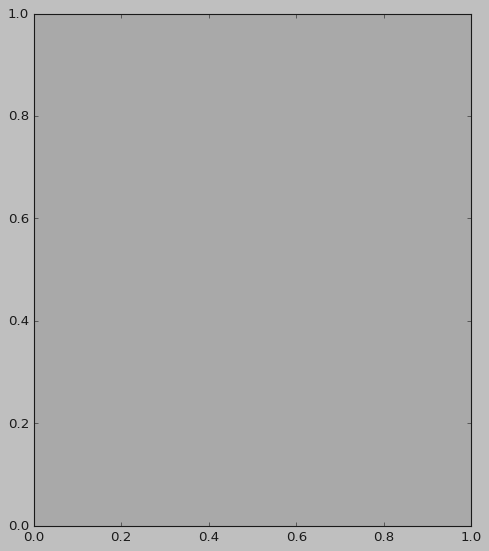

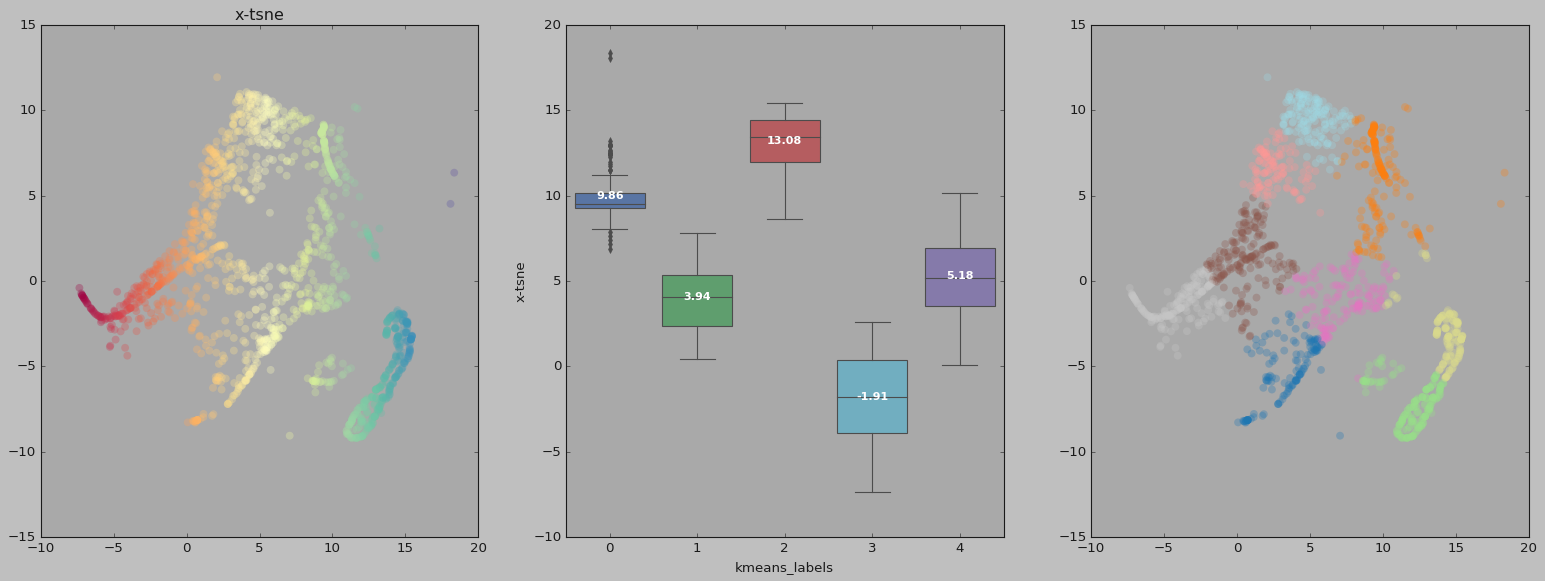

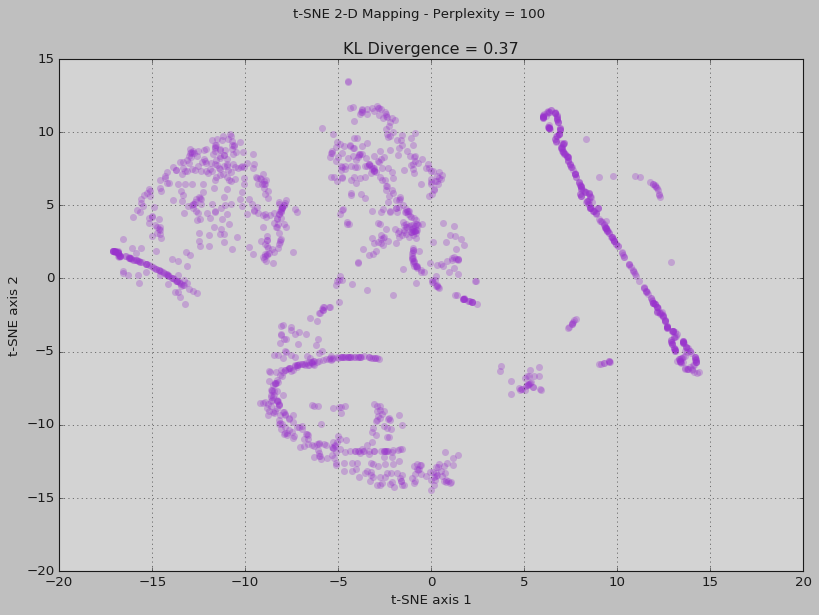

C:/Users/Preeti/Github/CapstoneProject/unsupervised/t_sne_mapping_perplex__0100_18.10.16.csv
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 601 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1469
[t-SNE] Computed conditional probabilities for sample 1469 / 1469
[t-SNE] Mean sigma: 2465.579445
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.258089
[t-SNE] Error after 250 iterations: 0.258089
57.9006367207694


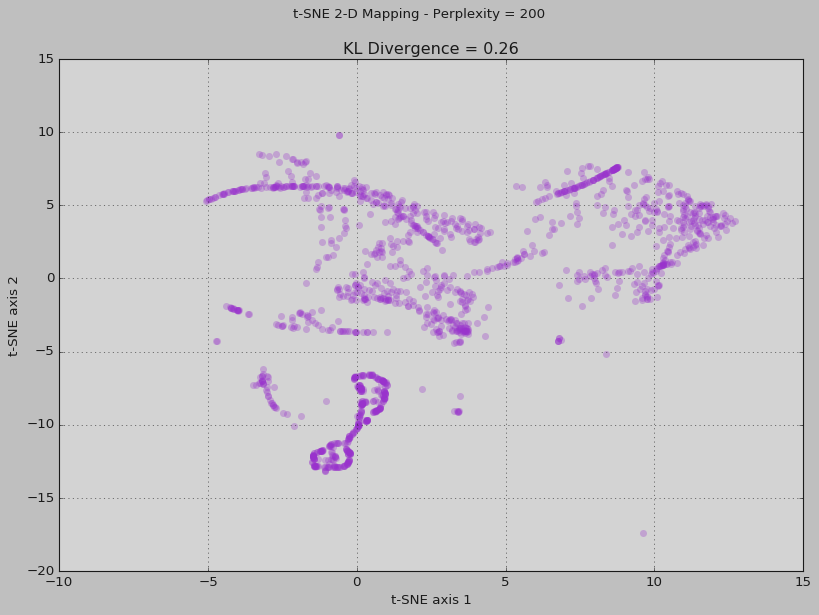

C:/Users/Preeti/Github/CapstoneProject/unsupervised/t_sne_mapping_perplex__0200_18.10.16.csv
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 901 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1469
[t-SNE] Computed conditional probabilities for sample 1469 / 1469
[t-SNE] Mean sigma: 4513.770486
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.162351
[t-SNE] Error after 275 iterations: 0.162351
85.57408926926291


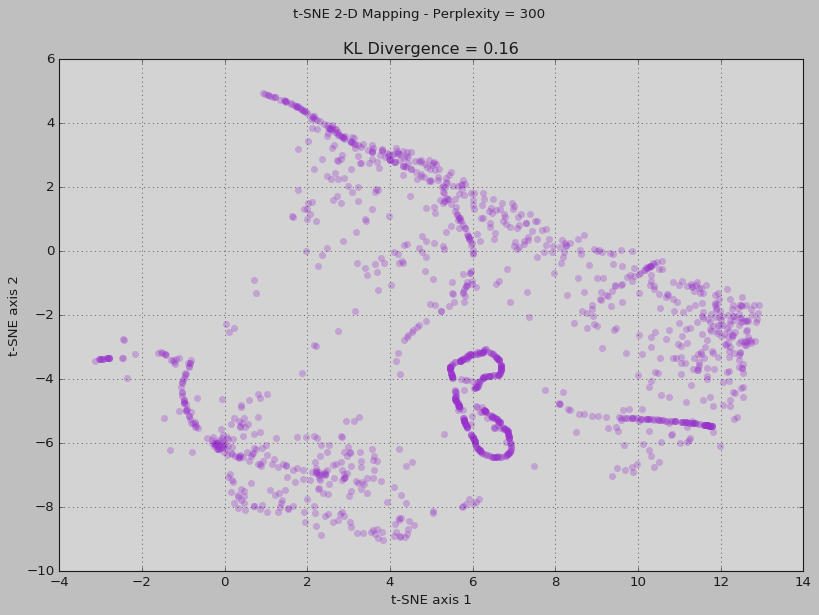

C:/Users/Preeti/Github/CapstoneProject/unsupervised/t_sne_mapping_perplex__0300_18.10.16.csv
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 1201 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1469
[t-SNE] Computed conditional probabilities for sample 1469 / 1469
[t-SNE] Mean sigma: 75171.770020
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.139785
[t-SNE] Error after 200 iterations: 0.139785
84.76917435048381


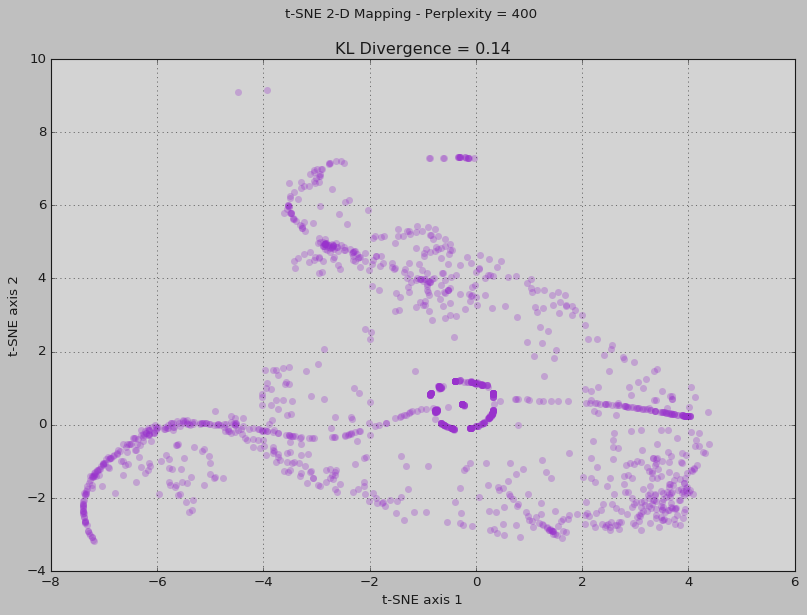

C:/Users/Preeti/Github/CapstoneProject/unsupervised/t_sne_mapping_perplex__0400_18.10.16.csv


In [160]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... t-sne for loop - evaluate range of perplexity values
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

for perplex in [100,200, 300,400] :

    i_index = i_index + 1
    tic = time.clock()

    tsne = TSNE(n_components = 2, verbose = 1, perplexity = perplex, n_iter = 300)

    tsne_results = tsne.fit_transform(X1)
    tsne_kl_diverge = tsne.kl_divergence_

    toc = time.clock()
    print (toc - tic)
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - save statistics for model comparison
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

    exe_time = '{0:.4f}'.format(toc-tic)
    
    raw_data = {
    'model_name' : 't-SNE - 2D',
    'perplexity' : perplex,
    'kl_divergence': tsne_kl_diverge,
    'process_time' : exe_time
    }

    df_tbl = pd.DataFrame(raw_data,
                            columns = ['model_name',
                                       'perplexity',
                                       'kl_divergence',
                                       'process_time'],
                            index = [i_index])
    
    tsne_tbl = tsne_tbl.append(df_tbl)

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - plot clusters
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

    _ = plt.figure(figsize = (12, 8))
    _ = plt.subplot(111, facecolor = 'lightgrey')
    
    _ = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                 s = 40,
                 c = 'darkorchid', 
                 linewidths = 0,
                 alpha = 0.30)
    
    _ = plt.xlabel('t-SNE axis 1')
    _ = plt.ylabel('t-SNE axis 2')
        
    _ = plt.suptitle("t-SNE 2-D Mapping - Perplexity = %d" %perplex)
    _ = plt.title("KL Divergence = %.2f" %tsne_kl_diverge)
    _ = plt.grid(True)
    
    data_dir = 'C:/Users/Preeti/Github/CapstoneProject/unsupervised/'
    data_file_base = "t_sne_mapping_perplex_"
    data_file_num = "%04d" %perplex
    #data_file_time = datetime.now().strftime("%Y%0m%0d_%H%M%S")
    data_file_time = '18.10.16'
    data_file_ext = ".png"
    plt_file_2_save = data_dir + data_file_base + data_file_num + data_file_time + data_file_ext
    
    plt.savefig(plt_file_2_save)

    plt.show();
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... store in ../data/ directory
# ... write as .csv file for future recall
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

    df_out['x-tsne'] = tsne_results[:,0];
    df_out['y-tsne'] = tsne_results[:,1];

    data_dir = 'C:/Users/Preeti/Github/CapstoneProject/unsupervised/'
    data_file_base = "t_sne_mapping_perplex_"
    data_file_num = "_%04d_" %perplex
    #data_file_time = datetime.now().strftime("%Y%0m%0d_%H%M%S")
    data_file_time = '18.10.16'
    data_file_ext = ".csv"
    file_2_write = data_dir + data_file_base + data_file_num + data_file_time + data_file_ext
    
    print(file_2_write)

    df_out.to_csv(file_2_write, index = False)
    
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# ... end of for loop on t-sne perplex
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=

In [240]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... read in t-SNE vectors
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
df_tsne = pd.read_csv('C:/Users/Preeti/Github/CapstoneProject/unsupervised/t_sne_mapping_perplex__0200_18.10.16.csv')
df_tsne.head()

x-tsne    y-tsne  sample_index
0 -3.490800 -7.276278          3645
1  2.215550  3.159925          1880
2  7.526734  6.370908          1376
3  2.384634 -2.414559          1798
4  3.470385 -0.954084          1416

In [242]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... join t-sne vectors with base data, since we sampled to create
# ...     the t-sne mapping
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

df_join = df_tsne.set_index('sample_index').join(df.set_index('slno'))
df_join.fillna('0',inplace=True)
df_join.head()

x-tsne    y-tsne cell_id      lat     long            Name  \
sample_index                                                                 
3645         -3.490800 -7.276278  950040   39.139 -84.5822        Westwood   
1880          2.215550  3.159925  590047  39.1547 -84.5009  North Avondale   
1376          7.526734  6.370908  450062  39.1885 -84.4692       Bond Hill   
1798          2.384634 -2.414559  570033  39.1232 -84.4963    Walnut Hills   
1416          3.470385 -0.954084  460066  39.1975 -84.4715        Roselawn   

             sum_cost num_fire_incd num_prop_sales num_streets  \
sample_index                                                     
3645            1.103             0              6           0   
1880                0             0             13           4   
1376                0             0              0           1   
1798                0             0             60          30   
1416                0             0              0          35   

                     ...         max_walk_score.imputed sum_lane_cnt.imputed  \
sample_index         ...                                                       
3645                 ...                             40                   53   
1880                 ...                             12                    8   
1376                 ...                             48                    3   
1798                 ...                             75                   83   
1416                 ...                             48                  105   

             sum_width.imputed sum_area.imputed categoryagricultural  \
sample_index                                                           
3645                       563           284640                    0   
1880                        88            79568                    0   
1376                        34            39957                    0   
1798                       827           144985                    0   
1416                       945           610439                    0   

             categorycommercial categoryindustrial categorypublicly.owned  \
sample_index                                                                
3645                          0                  0                      0   
1880                          0                  0                      0   
1376                          0                  0                      0   
1798                          0                  0                      0   
1416                          0                  0                      0   

             categorypublic.utilities categoryresidential  
sample_index                                               
3645                                0                   1  
1880                                0                   1  
1376                                0                   0  
1798                                0                   1  
1416                                0                   0  

[5 rows x 27 columns]

In [243]:
col_names = df_join.columns.values.tolist()
col_names
df_join.describe().T


['x-tsne',
 'y-tsne',
 'cell_id',
 'lat',
 'long',
 'Name',
 'sum_cost',
 'num_fire_incd',
 'num_prop_sales',
 'num_streets',
 'num_walk_scores',
 'num_reports',
 'num_near_misses',
 'median_sale_price.imputed',
 'max_sale_price.imputed',
 'mean_walk_score.imputed',
 'min_walk_score.imputed',
 'max_walk_score.imputed',
 'sum_lane_cnt.imputed',
 'sum_width.imputed',
 'sum_area.imputed',
 'categoryagricultural',
 'categorycommercial',
 'categoryindustrial',
 'categorypublicly.owned',
 'categorypublic.utilities',
 'categoryresidential']

count      mean       std        min       25%       50%       75%  \
x-tsne  1469.0  2.928007  4.618919  -5.081849 -0.334625  1.128415  7.309638   
y-tsne  1469.0 -0.688551  6.262044 -17.429490 -6.694878  0.444996  4.819394   

              max  
x-tsne  12.719598  
y-tsne   9.809177

In [166]:
# set required variables for model comparison

kmeans_tbl = pd.DataFrame(columns = [
    'model_name',
    'n_clusters',
    'inertia',
    'silhouette',
    'process_time'])

i_index = []
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

n_lda =  2


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  38208.77382930173
silhouette =  0.4918057398340193
0 4.823747141351397 3.7787671074357223 0
1 0.15119264804561627 -7.2321238556236525 1


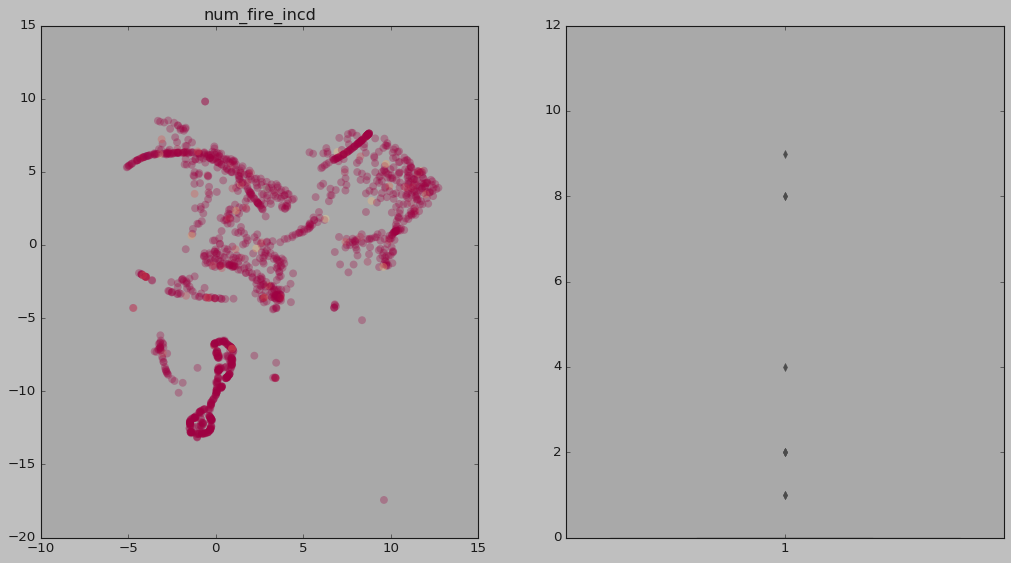

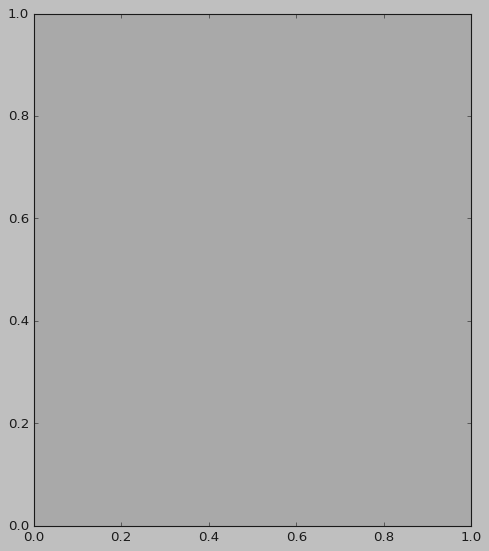

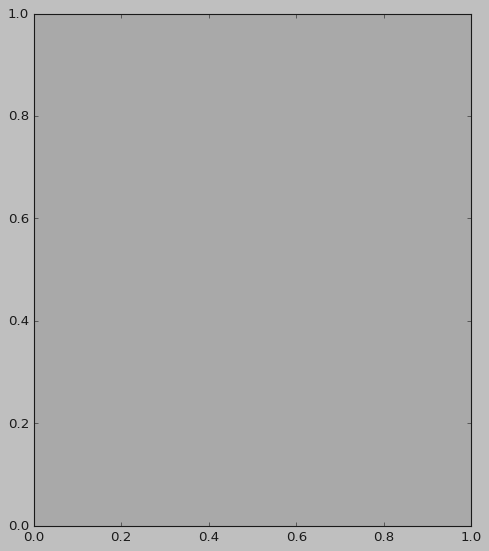

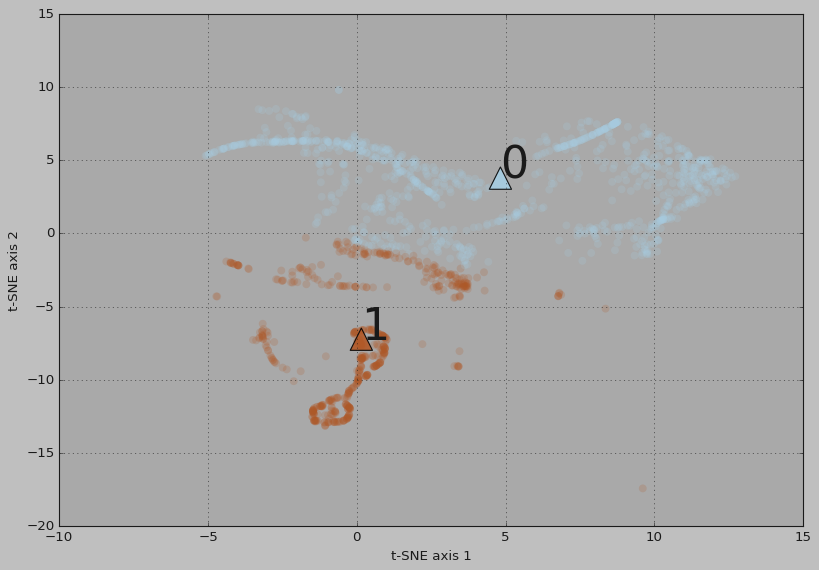

n_lda =  3


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  20096.143803547686
silhouette =  0.5195240110272562
0 9.338137944523655 3.8224919785930456 0
1 0.23123625550063753 -8.258764008365095 1
2 0.33290017504272607 2.7780080673281597 2


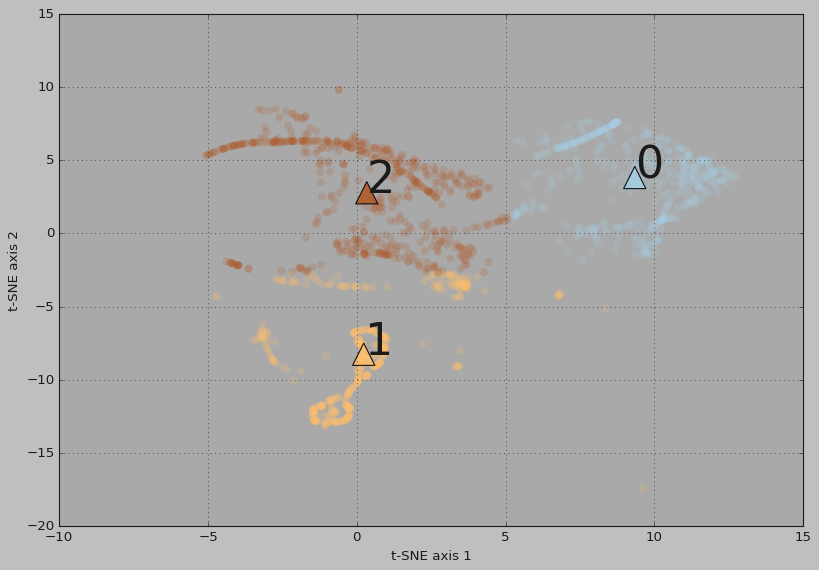

n_lda =  4


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  12221.375385444608
silhouette =  0.5490820464036911
0 -0.09530505066000572 4.956006438263825 0
1 -0.30350160269270754 -9.67493569504742 1
2 9.338137944523655 3.8224919785930456 2
3 1.4267148620238703 -1.9138758764145543 3


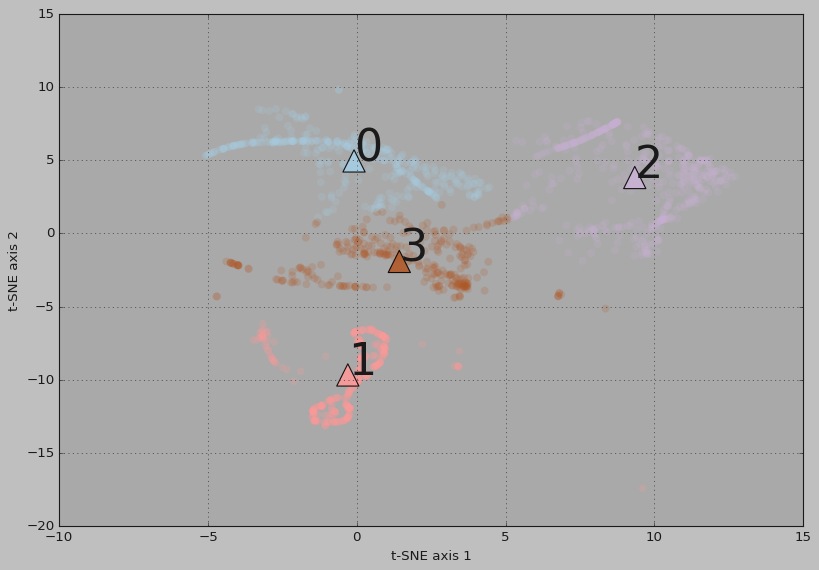

n_lda =  5


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  10123.645034350027
silhouette =  0.5350756346986809
0 8.717207747933664 0.3950297052415582 0
1 -0.30350160269270754 -9.67493569504742 1
2 -0.09530505066000572 4.956006438263825 2
3 1.21399432430453 -1.9235134857008203 3
4 9.489081897678533 5.279533585553115 4


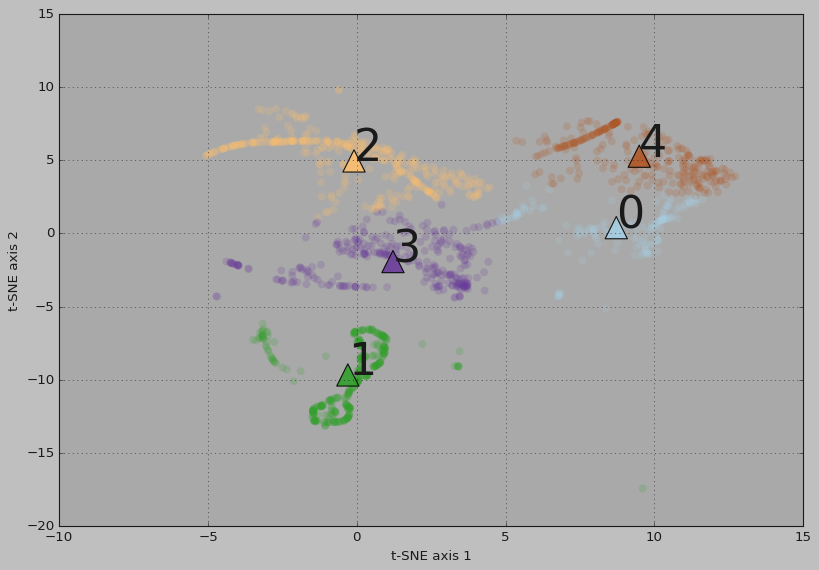

n_lda =  6


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  8301.714087331968
silhouette =  0.5589447257389967
0 9.482921011907312 5.289091006876923 0
1 -0.30350160269270754 -9.67493569504742 1
2 1.82503616681524 3.6680171461812123 2
3 1.2202724862741 -1.9273528072265753 3
4 8.761648957379839 0.4062530792915692 4
5 -2.020900305399008 6.241482096920137 5


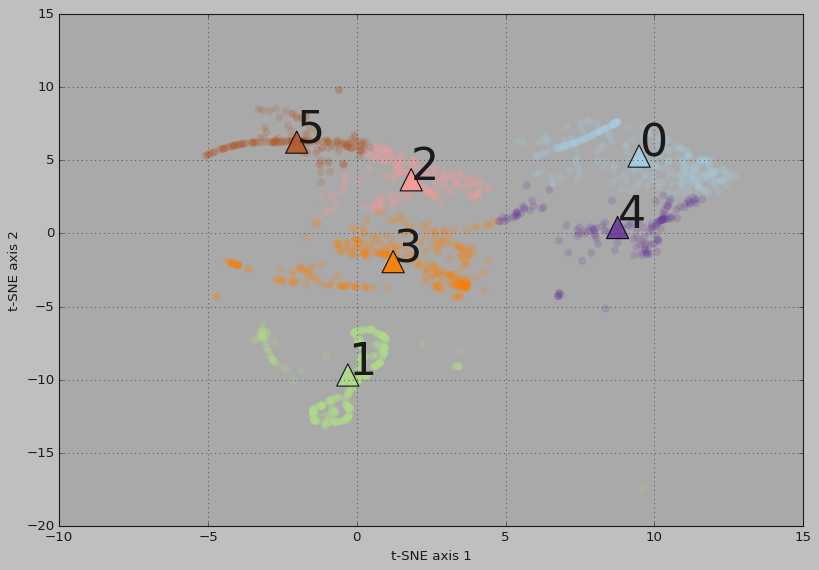

n_lda =  7


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  6743.510740300824
silhouette =  0.5740784345645696
0 9.482921011907312 5.289091006876923 0
1 1.2202724862741 -1.9273528072265753 1
2 -0.0197569844767167 -7.9961051607604725 2
3 -2.020900305399008 6.241482096920137 3
4 8.761648957379839 0.4062530792915692 4
5 1.82503616681524 3.6680171461812123 5
6 -0.6975913502149229 -12.006644770445957 6


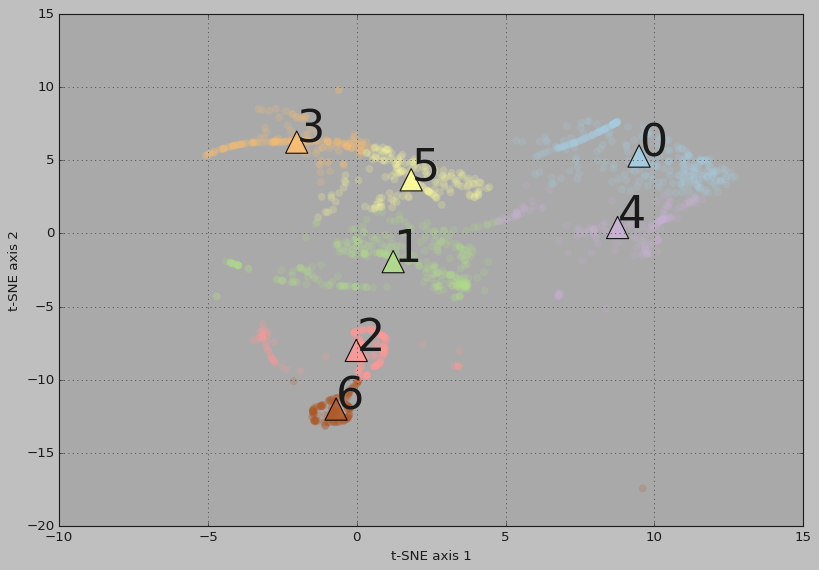

n_lda =  8


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  5638.480094165445
silhouette =  0.6181392125743855
0 -0.0197569844767167 -7.9961051607604725 0
1 2.7981538677885434 -1.9365223576912856 1
2 9.482921011907312 5.289091006876923 2
3 -2.020900305399008 6.241482096920137 3
4 -0.6975913502149229 -12.006644770445957 4
5 1.82503616681524 3.6680171461812123 5
6 8.761648957379839 0.4062530792915692 6
7 -1.120251562972324 -1.9137513073705863 7


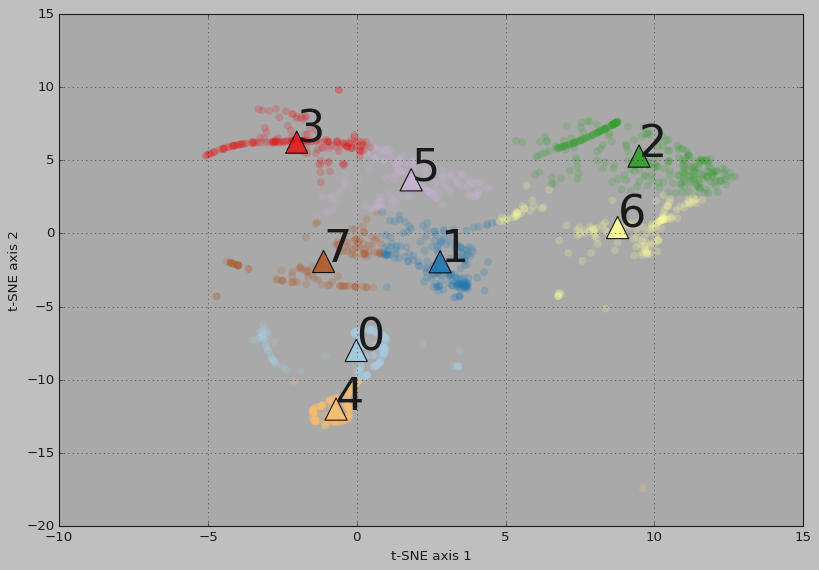

n_lda =  9


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  4601.690902516608
silhouette =  0.665263613103899
0 -0.6975913502149229 -12.006644770445957 0
1 1.82503616681524 3.6680171461812123 1
2 2.7981538677885434 -1.9365223576912856 2
3 7.890472763592948 6.402170996298185 3
4 -2.020900305399008 6.241482096920137 4
5 -0.0197569844767167 -7.9961051607604725 5
6 8.761648957379839 0.4062530792915692 6
7 -1.120251562972324 -1.9137513073705863 7
8 10.970602928095715 4.249239964128127 8


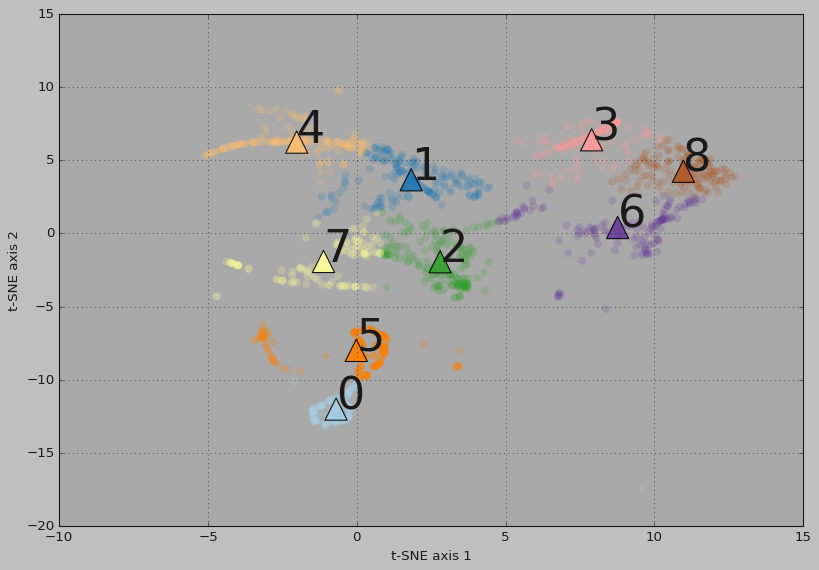

In [244]:
# ... k-means on the t-sne vectors

X_tsne = pd.DataFrame(columns=['t1', 't2'])
X_tsne['t1'] = df_join['x-tsne']
X_tsne['t2'] = df_join['y-tsne']

for n_lda in range(2, 10):  

    tic = time.clock()
    
    print ("n_lda = ", n_lda)

    cls_lda = KMeans(n_clusters = n_lda,
                     init = 'k-means++',
                     random_state = 1);
    
    cls_lda.fit(X_tsne)

    kmeans_labels = cls_lda.labels_ # the labels from kmeans clustering
    kmeans_centers = cls_lda.cluster_centers_

    kmeans_inertia = cls_lda.inertia_
    print ("inertia = ", kmeans_inertia)
    
    kmeans_silhouette = metrics.silhouette_score(X_tsne,
                                                 kmeans_labels,
                                                 metric = 'euclidean',
                                                 sample_size = 10000)
    print ("silhouette = ", kmeans_silhouette)
    column_name = "kmeans_" + str(n_lda)
    df_join[column_name] = kmeans_labels

    toc =  time.clock()
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - save statistics for model comparison
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

    exe_time = '{0:.4f}'.format(toc-tic)
    
    raw_data = {
    'model_name' : 'KMeans - LDA features',
    'n_clusters' : n_lda,
    'inertia': kmeans_inertia,
    'silhouette': kmeans_silhouette, 
    'process_time' : exe_time
    }

    df_tbl = pd.DataFrame(raw_data,
    columns = ['model_name', 'n_clusters', 'inertia', 'silhouette', 'process_time'],
    index = [i_index + 1])

    kmeans_tbl = kmeans_tbl.append(df_tbl, ignore_index=True)
    column_name = "kmeans_" + str(n_lda)
    X_tsne[column_name] = kmeans_labels
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - make some plots of clusters
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
    
    _ = plt.figure(figsize=(12, 8));
    _ = plt.subplot(111, facecolor = 'darkgrey');
    
    X_tsne_values = X_tsne.values;
    _ = plt.scatter(X_tsne_values[:, 0], X_tsne_values[:, 1],
                c = kmeans_labels,
                cmap = plt.cm.Paired,
                s = 50,
                linewidths = 0,
                alpha = 0.20);
    _ = plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1],
                c = range(n_lda),
                cmap = plt.cm.Paired,
                s = 400,
                linewidths = 1.0,
                marker = '^',
                edgecolors = 'black',
                alpha = 0.90);
    
    for ii in range(n_lda) :                                       
        _ = plt.text(kmeans_centers[ii, 0], kmeans_centers[ii, 1], ii, fontsize = 40)
        print(ii, kmeans_centers[ii, 0], kmeans_centers[ii, 1], ii)
    
    _ = plt.xlabel('t-SNE axis 1')
    _ = plt.ylabel('t-SNE axis 2');
    _ = plt.grid(True);

    plt.show();

In [ ]:
## Run k means again for the finalized custer # to recreate centers and labels
n_lda = 5 

In [283]:

# ... k-means on the t-sne vectors

X_tsne = pd.DataFrame(columns=['t1', 't2'])
X_tsne['t1'] = df_join['x-tsne']
X_tsne['t2'] = df_join['y-tsne']

print ("n_lda = ", n_lda)

cls_lda = KMeans(n_clusters = n_lda,
                 init = 'k-means++',
                 random_state = 1);

cls_lda.fit(X_tsne)

kmeans_labels = cls_lda.labels_ # the labels from kmeans clustering
kmeans_centers = cls_lda.cluster_centers_

kmeans_inertia = cls_lda.inertia_
print ("inertia = ", kmeans_inertia)

kmeans_silhouette = metrics.silhouette_score(X_tsne,
                                             kmeans_labels,
                                             metric = 'euclidean',
                                             sample_size = 10000)
print ("silhouette = ", kmeans_silhouette)
#column_name = "kmeans_" + str(n_lda)
#df_join[column_name] = kmeans_labels


n_lda =  5


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1, tol=0.0001, verbose=0)

inertia =  9936.41891048427
silhouette =  0.5159610292025396


In [245]:
df_join.head()

x-tsne    y-tsne cell_id      lat     long            Name  \
sample_index                                                                 
3645         -3.490800 -7.276278  950040   39.139 -84.5822        Westwood   
1880          2.215550  3.159925  590047  39.1547 -84.5009  North Avondale   
1376          7.526734  6.370908  450062  39.1885 -84.4692       Bond Hill   
1798          2.384634 -2.414559  570033  39.1232 -84.4963    Walnut Hills   
1416          3.470385 -0.954084  460066  39.1975 -84.4715        Roselawn   

             sum_cost num_fire_incd num_prop_sales num_streets   ...     \
sample_index                                                     ...      
3645            1.103             0              6           0   ...      
1880                0             0             13           4   ...      
1376                0             0              0           1   ...      
1798                0             0             60          30   ...      
1416                0             0              0          35   ...      

             categorypublic.utilities categoryresidential kmeans_2 kmeans_3  \
sample_index                                                                  
3645                                0                   1        1        1   
1880                                0                   1        0        2   
1376                                0                   0        0        0   
1798                                0                   1        1        2   
1416                                0                   0        0        2   

             kmeans_4 kmeans_5 kmeans_6 kmeans_7 kmeans_8 kmeans_9  
sample_index                                                        
3645                1        1        1        2        0        5  
1880                0        2        2        5        5        1  
1376                2        4        0        0        2        3  
1798                3        3        3        1        1        2  
1416                3        3        3        1        1        2  

[5 rows x 35 columns]

In [185]:
df_lat = df[['slno','cell_id','lat','long']]
master = df_join.join(df_lat.set_index('slno'))
master.head()

x-tsne    y-tsne  num_fire_incd  num_prop_sales  num_streets  \
sample_index                                                                   
3645         -3.490800 -7.276278            0.0             6.0          0.0   
1880          2.215550  3.159925            0.0            13.0          4.0   
1376          7.526734  6.370908            0.0             0.0          1.0   
1798          2.384634 -2.414559            0.0            60.0         30.0   
1416          3.470385 -0.954084            0.0             0.0         35.0   

              num_walk_scores  num_reports  num_near_misses  \
sample_index                                                  
3645                      1.0          0.0              0.0   
1880                      1.0          0.0              0.0   
1376                      0.0          0.0              0.0   
1798                      2.0          0.0              0.0   
1416                      0.0          0.0              0.0   

              median_sale_price.imputed  max_sale_price.imputed    ...      \
sample_index                                                       ...       
3645                            48500.0                100000.0    ...       
1880                            64444.0                299000.0    ...       
1376                            82700.0                323000.0    ...       
1798                            55500.0              20000000.0    ...       
1416                            82700.0                323000.0    ...       

              kmeans_3  kmeans_4  kmeans_5  kmeans_6  kmeans_7  kmeans_8  \
sample_index                                                               
3645                 1         1         1         1         2         0   
1880                 2         0         2         2         5         5   
1376                 0         2         4         0         0         2   
1798                 2         3         3         3         1         1   
1416                 2         3         3         3         1         1   

              kmeans_9   cell_id        lat       long  
sample_index                                            
3645                 5  950040.0  39.138993 -84.582195  
1880                 1  590047.0  39.154744 -84.500864  
1376                 3  450062.0  39.188479 -84.469235  
1798                 2  570033.0  39.123243 -84.496345  
1416                 2  460066.0  39.197481 -84.471494  

[5 rows x 85 columns]

In [246]:
df_join.head()

x-tsne    y-tsne cell_id      lat     long            Name  \
sample_index                                                                 
3645         -3.490800 -7.276278  950040   39.139 -84.5822        Westwood   
1880          2.215550  3.159925  590047  39.1547 -84.5009  North Avondale   
1376          7.526734  6.370908  450062  39.1885 -84.4692       Bond Hill   
1798          2.384634 -2.414559  570033  39.1232 -84.4963    Walnut Hills   
1416          3.470385 -0.954084  460066  39.1975 -84.4715        Roselawn   

             sum_cost num_fire_incd num_prop_sales num_streets   ...     \
sample_index                                                     ...      
3645            1.103             0              6           0   ...      
1880                0             0             13           4   ...      
1376                0             0              0           1   ...      
1798                0             0             60          30   ...      
1416                0             0              0          35   ...      

             categorypublic.utilities categoryresidential kmeans_2 kmeans_3  \
sample_index                                                                  
3645                                0                   1        1        1   
1880                                0                   1        0        2   
1376                                0                   0        0        0   
1798                                0                   1        1        2   
1416                                0                   0        0        2   

             kmeans_4 kmeans_5 kmeans_6 kmeans_7 kmeans_8 kmeans_9  
sample_index                                                        
3645                1        1        1        2        0        5  
1880                0        2        2        5        5        1  
1376                2        4        0        0        2        3  
1798                3        3        3        1        1        2  
1416                3        3        3        1        1        2  

[5 rows x 35 columns]

In [247]:
X_all_together = copy.deepcopy(df_join)
len(X_all_together)
X_all_together['kmeans_labels'] = df_join['kmeans_5']

1469

In [248]:
X_all_together.fillna('0',inplace=True)
X_all_together.isnull().sum()

x-tsne                       0
y-tsne                       0
cell_id                      0
lat                          0
long                         0
Name                         0
sum_cost                     0
num_fire_incd                0
num_prop_sales               0
num_streets                  0
num_walk_scores              0
num_reports                  0
num_near_misses              0
median_sale_price.imputed    0
max_sale_price.imputed       0
mean_walk_score.imputed      0
min_walk_score.imputed       0
max_walk_score.imputed       0
sum_lane_cnt.imputed         0
sum_width.imputed            0
sum_area.imputed             0
categoryagricultural         0
categorycommercial           0
categoryindustrial           0
categorypublicly.owned       0
categorypublic.utilities     0
categoryresidential          0
kmeans_2                     0
kmeans_3                     0
kmeans_4                     0
kmeans_5                     0
kmeans_6                     0
kmeans_7

In [249]:
master.to_csv("df_model_with_kmeans.csv", index=False)

In [276]:
col_names = X_all_together.columns.values.tolist()

In [277]:
col_names

['x-tsne',
 'y-tsne',
 'cell_id',
 'lat',
 'long',
 'Name',
 'sum_cost',
 'num_fire_incd',
 'num_prop_sales',
 'num_streets',
 'num_walk_scores',
 'num_reports',
 'num_near_misses',
 'median_sale_price.imputed',
 'max_sale_price.imputed',
 'mean_walk_score.imputed',
 'min_walk_score.imputed',
 'max_walk_score.imputed',
 'sum_lane_cnt.imputed',
 'sum_width.imputed',
 'sum_area.imputed',
 'categoryagricultural',
 'categorycommercial',
 'categoryindustrial',
 'categorypublicly.owned',
 'categorypublic.utilities',
 'categoryresidential',
 'kmeans_2',
 'kmeans_3',
 'kmeans_4',
 'kmeans_5',
 'kmeans_6',
 'kmeans_7',
 'kmeans_8',
 'kmeans_9',
 'kmeans_labels']

## Remove columns for which plot is not needed

In [278]:
col_to_remove = ['x-tsne','y-tsne','cell_id', 'lat', 'long', 'Name','kmeans_2', 'kmeans_3', 'kmeans_4', 'kmeans_5', 'kmeans_6', 'kmeans_7', 'kmeans_8','kmeans_9','sum_cost']
for col in col_to_remove:
    col_names.remove(col)

In [279]:
col_names

['num_fire_incd',
 'num_prop_sales',
 'num_streets',
 'num_walk_scores',
 'num_reports',
 'num_near_misses',
 'median_sale_price.imputed',
 'max_sale_price.imputed',
 'mean_walk_score.imputed',
 'min_walk_score.imputed',
 'max_walk_score.imputed',
 'sum_lane_cnt.imputed',
 'sum_width.imputed',
 'sum_area.imputed',
 'categoryagricultural',
 'categorycommercial',
 'categoryindustrial',
 'categorypublicly.owned',
 'categorypublic.utilities',
 'categoryresidential',
 'kmeans_labels']

## Convert numeric columns from object to float

In [280]:
X_all_together.select_dtypes(include=['object']).columns
col_to_convert_to_float = ['num_fire_incd',
       'num_streets', 'num_walk_scores', 'num_reports', 'num_near_misses',
       'median_sale_price.imputed', 'max_sale_price.imputed',
       'mean_walk_score.imputed', 'min_walk_score.imputed',
       'max_walk_score.imputed', 'sum_lane_cnt.imputed', 'sum_width.imputed',
       'sum_area.imputed', 'categoryagricultural', 'categorycommercial',
       'categoryindustrial', 'categorypublicly.owned',
       'categorypublic.utilities', 'categoryresidential']

Index(['cell_id', 'lat', 'long', 'Name', 'sum_cost'], dtype='object')

In [281]:
for col in col_to_convert_to_float:
    X_all_together[col] = X_all_together[col].astype(float).fillna(0.0)

In [289]:
kmeans_weight_tbl = pd.DataFrame(columns = [
    'Column Name',
    'cluster 0',
    'cluster 1',
    'cluster 2',
    'cluster 3',
    'cluster 4'])

i_index = []
i_index = 0

************************** num_fire_incd
****************************************


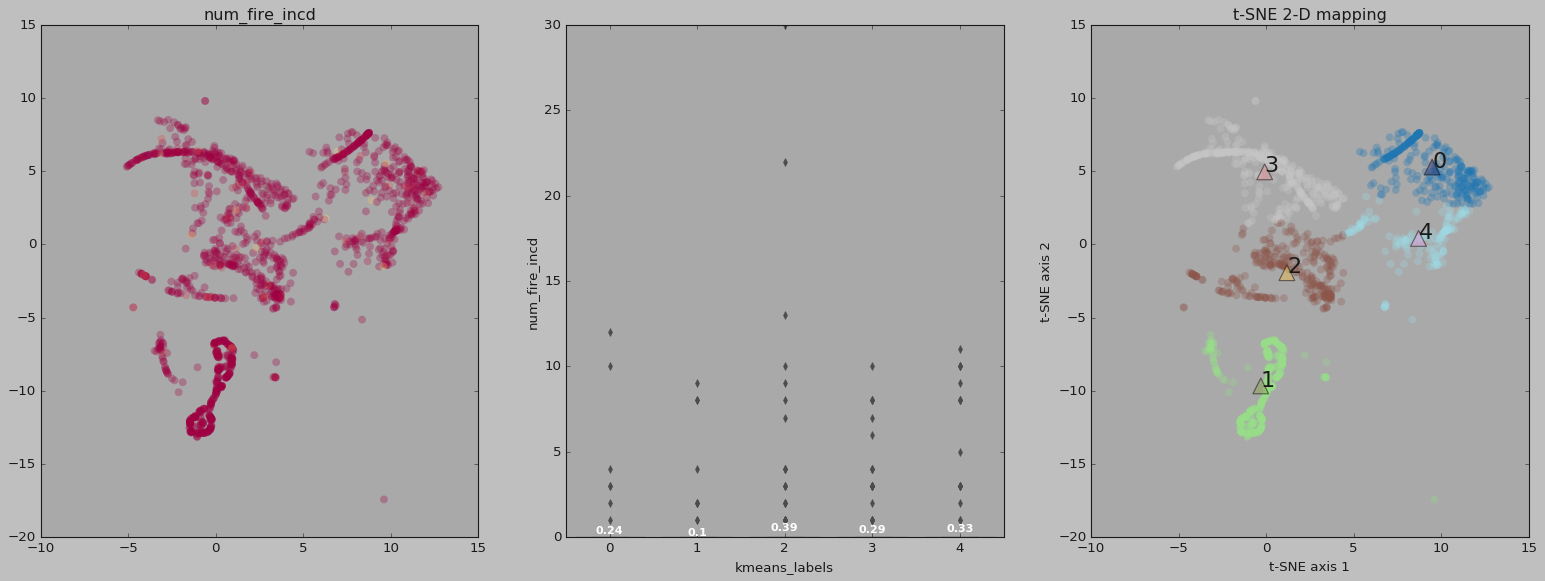

************************** num_prop_sales
****************************************


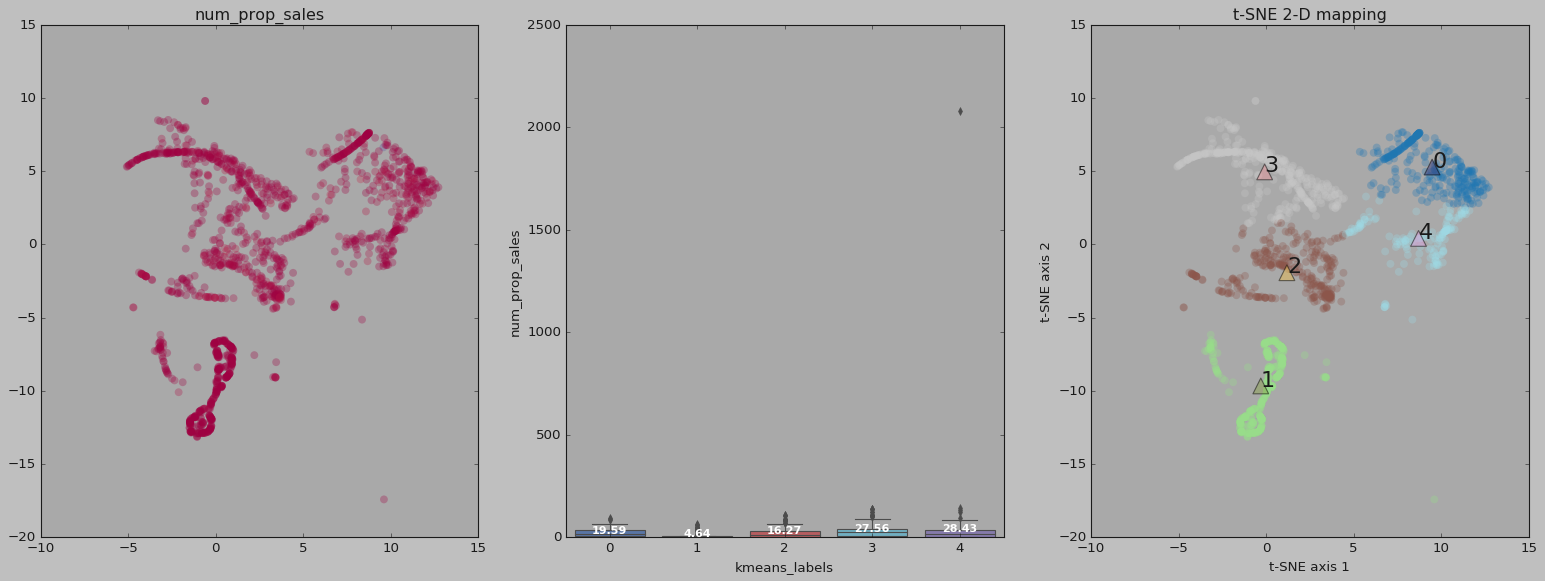

************************** num_streets
****************************************


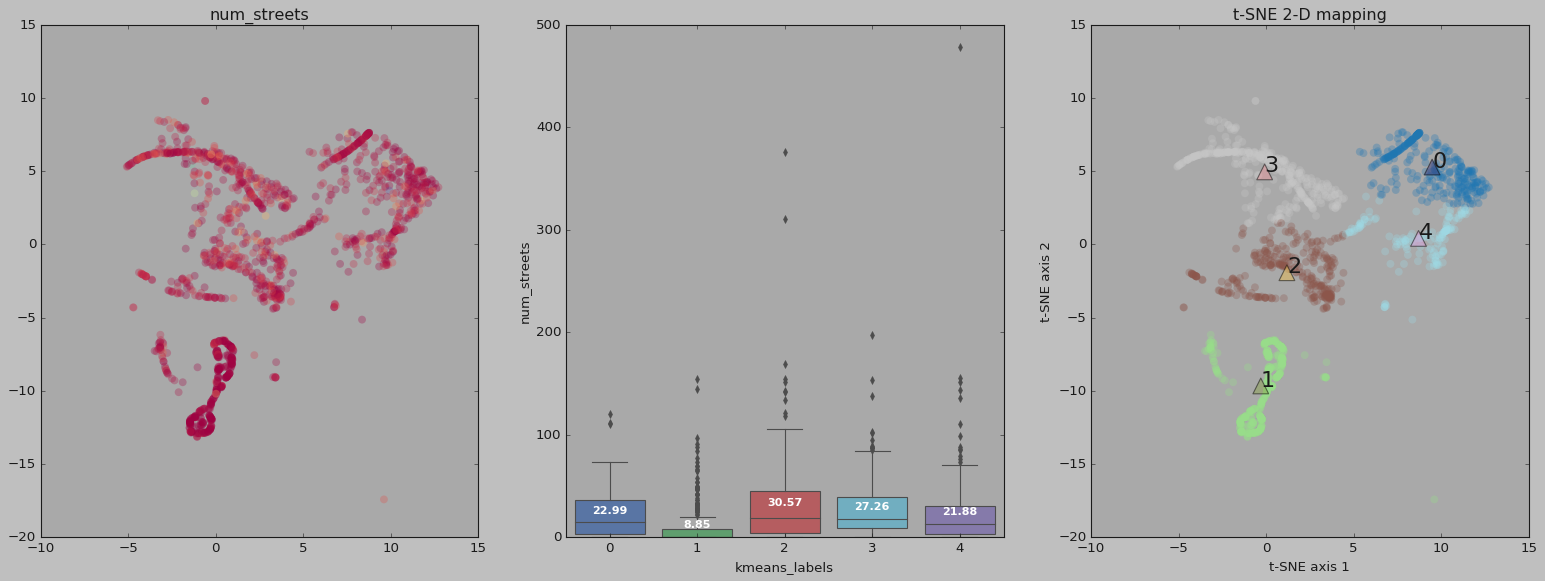

************************** num_walk_scores
****************************************


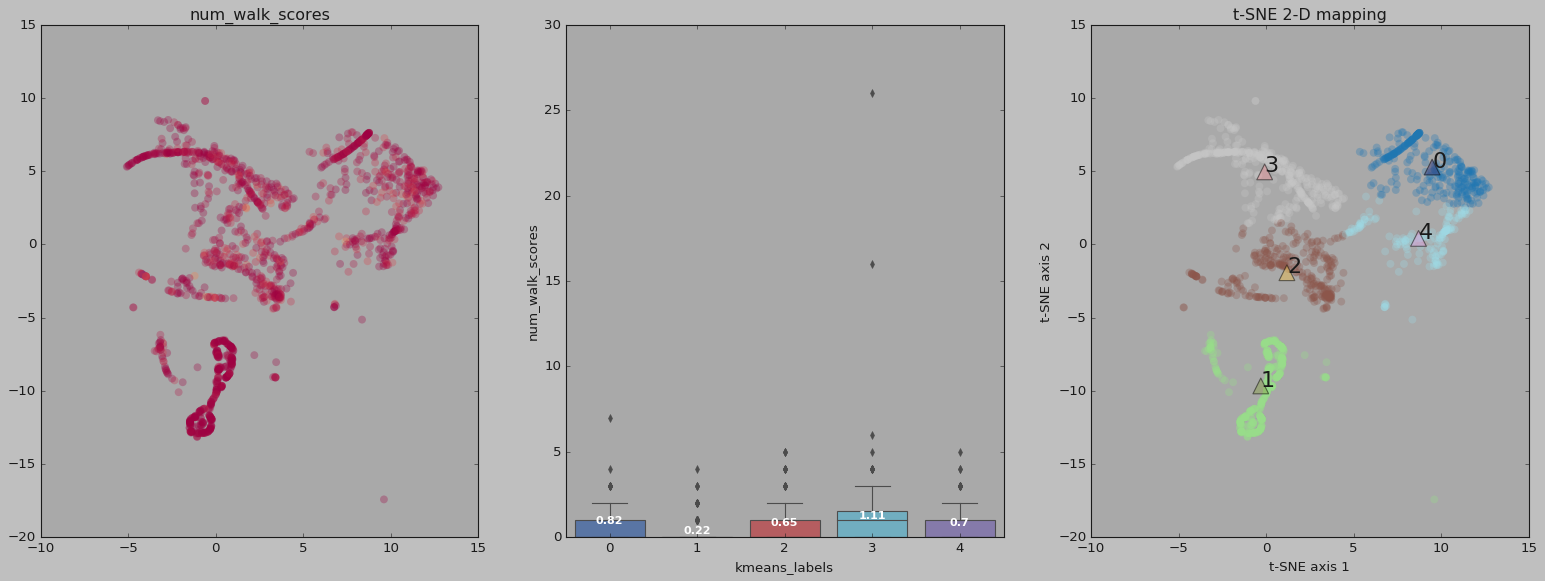

************************** num_reports
****************************************


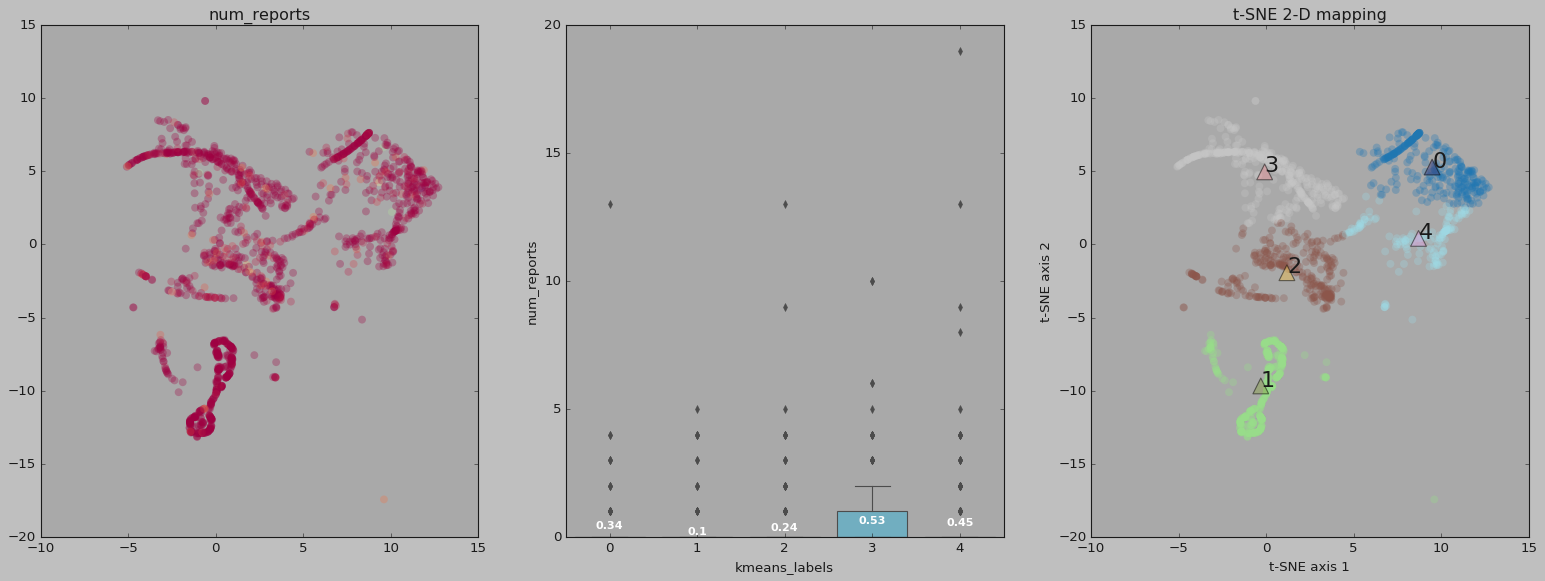

************************** num_near_misses
****************************************


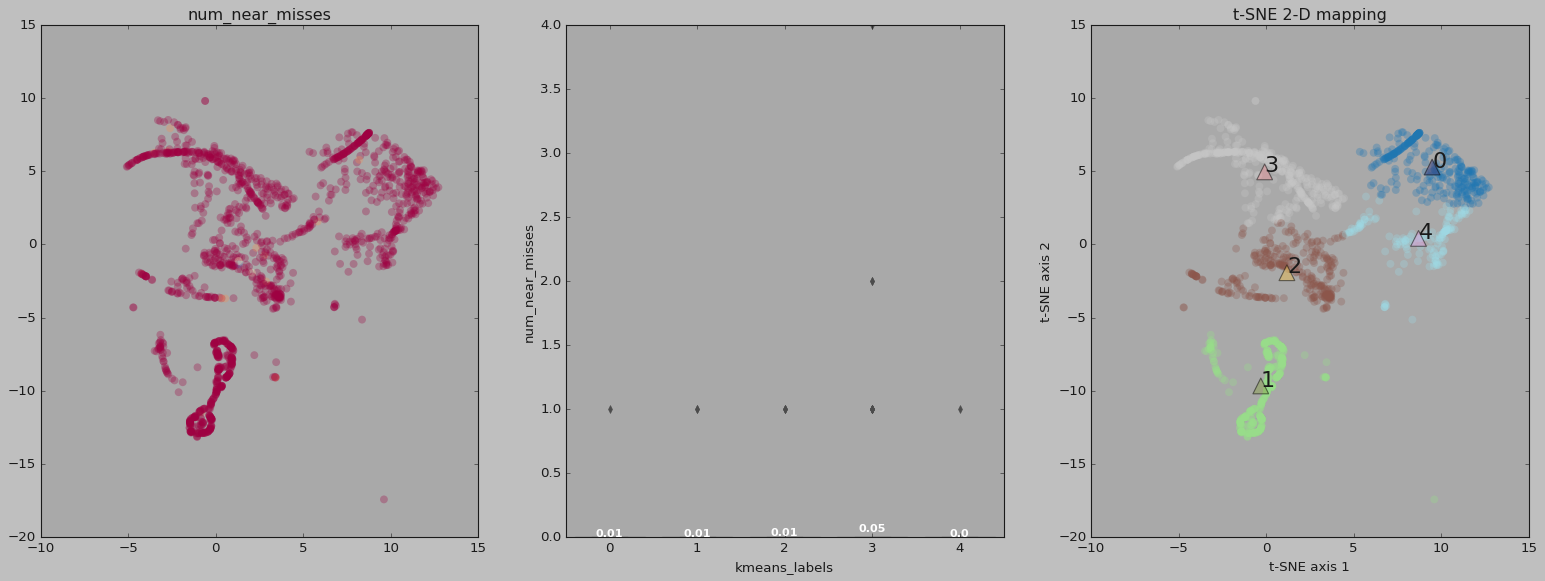

************************** median_sale_price.imputed
****************************************


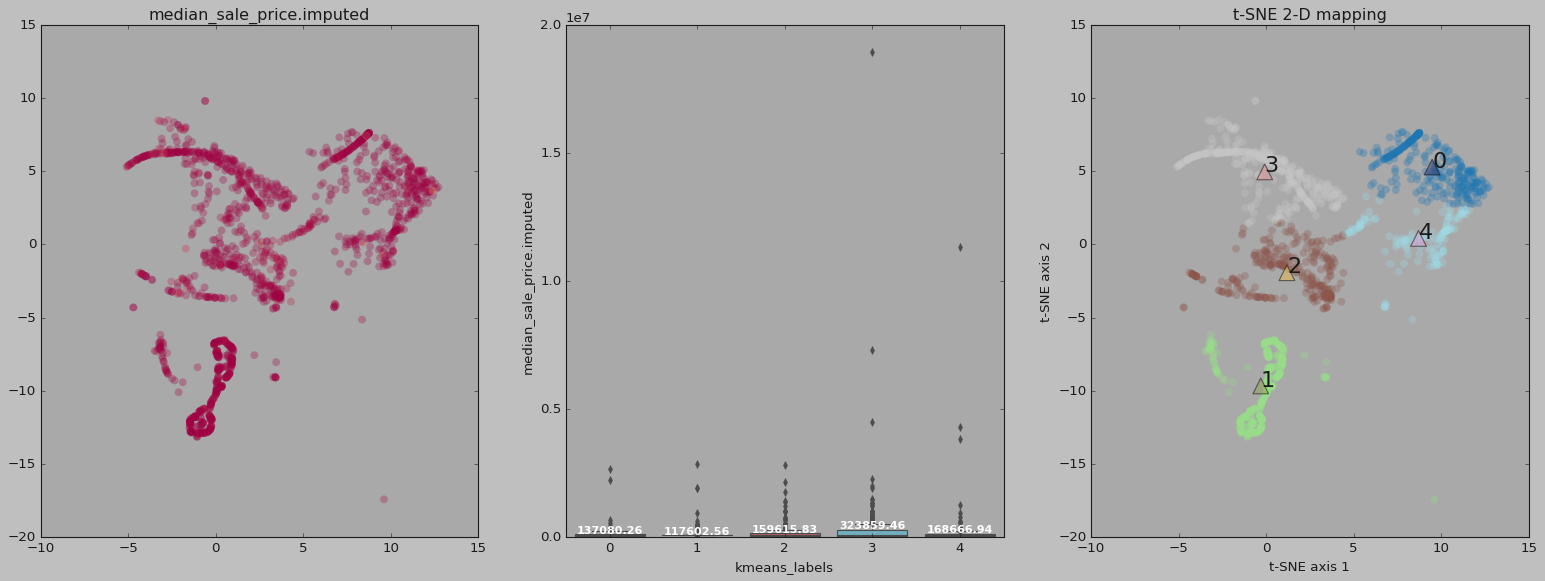

************************** max_sale_price.imputed
****************************************


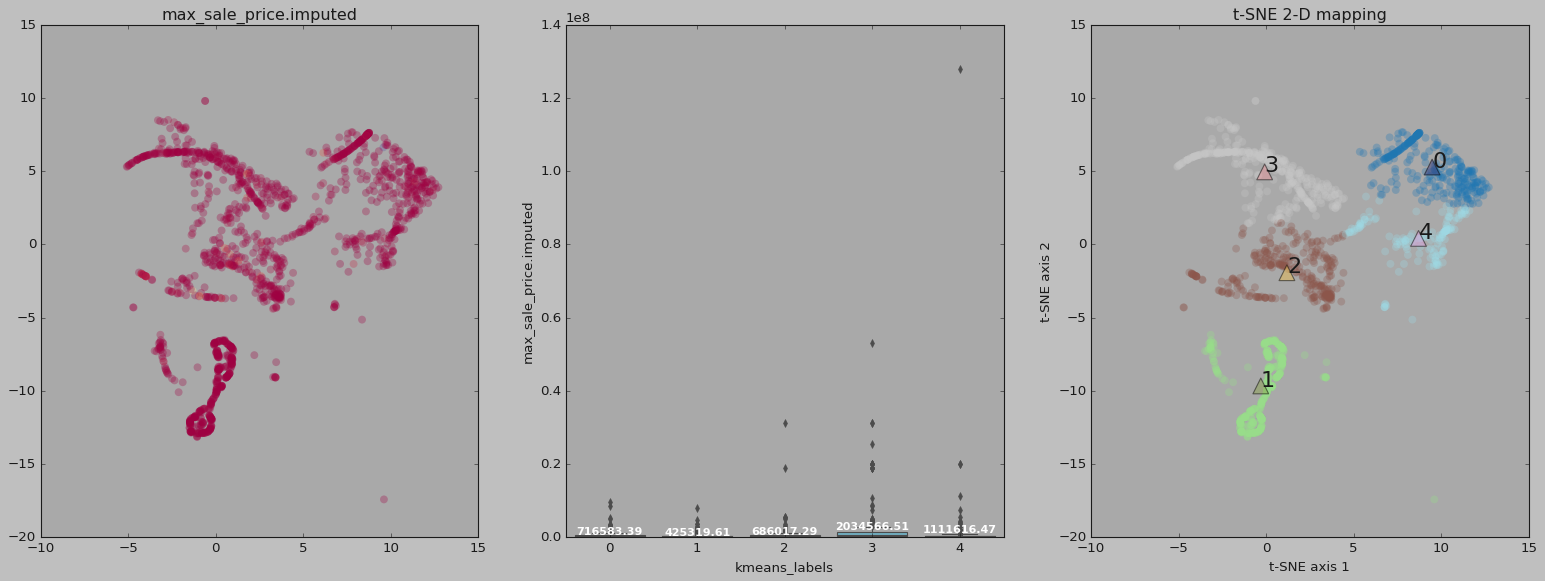

************************** mean_walk_score.imputed
****************************************


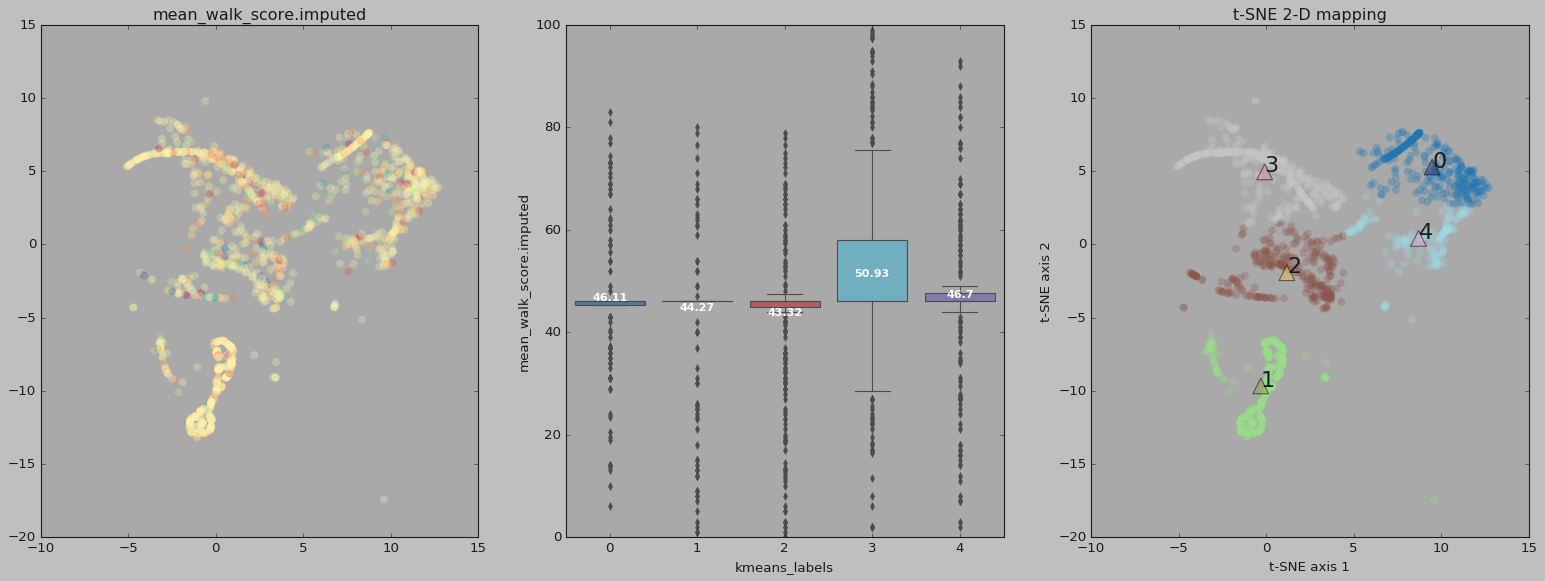

************************** min_walk_score.imputed
****************************************


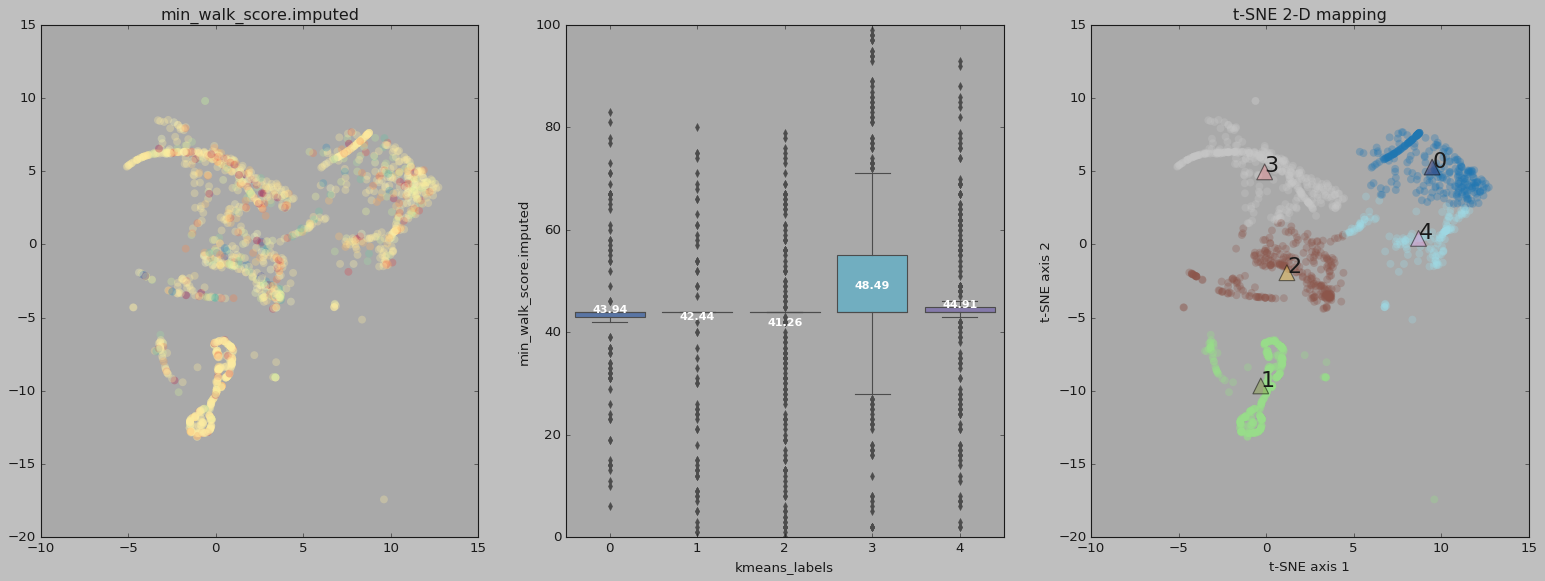

************************** max_walk_score.imputed
****************************************


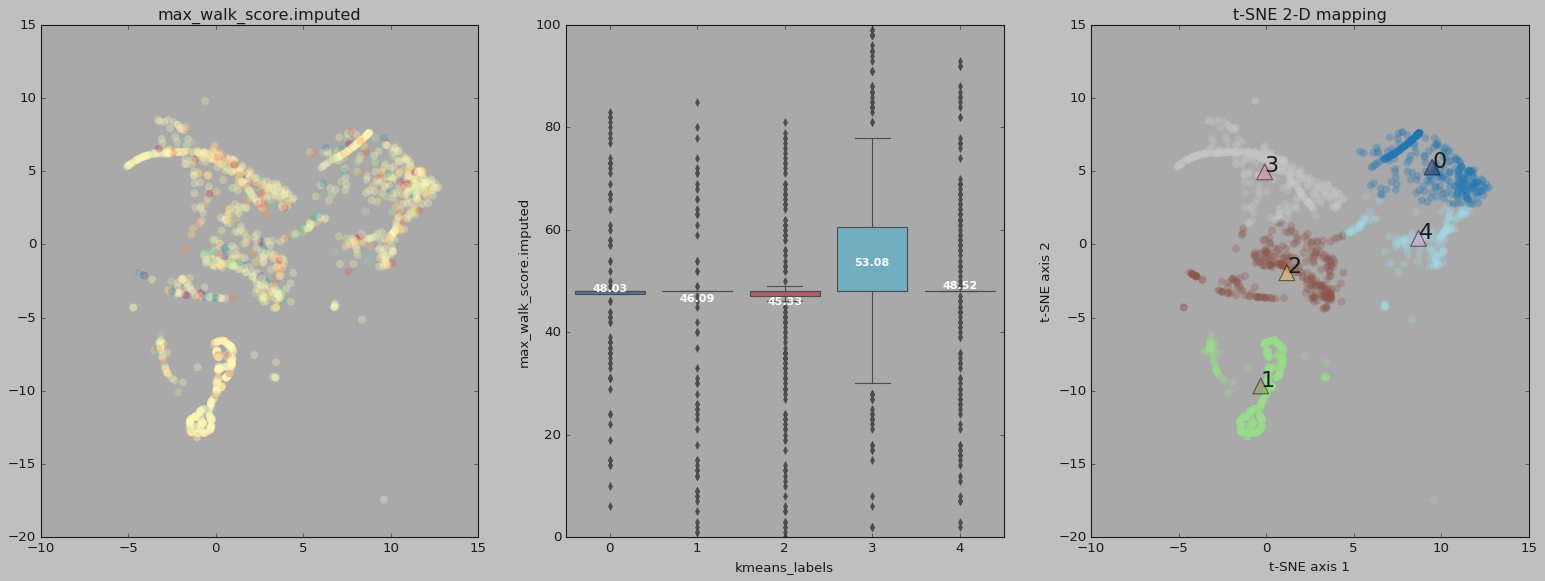

************************** sum_lane_cnt.imputed
****************************************


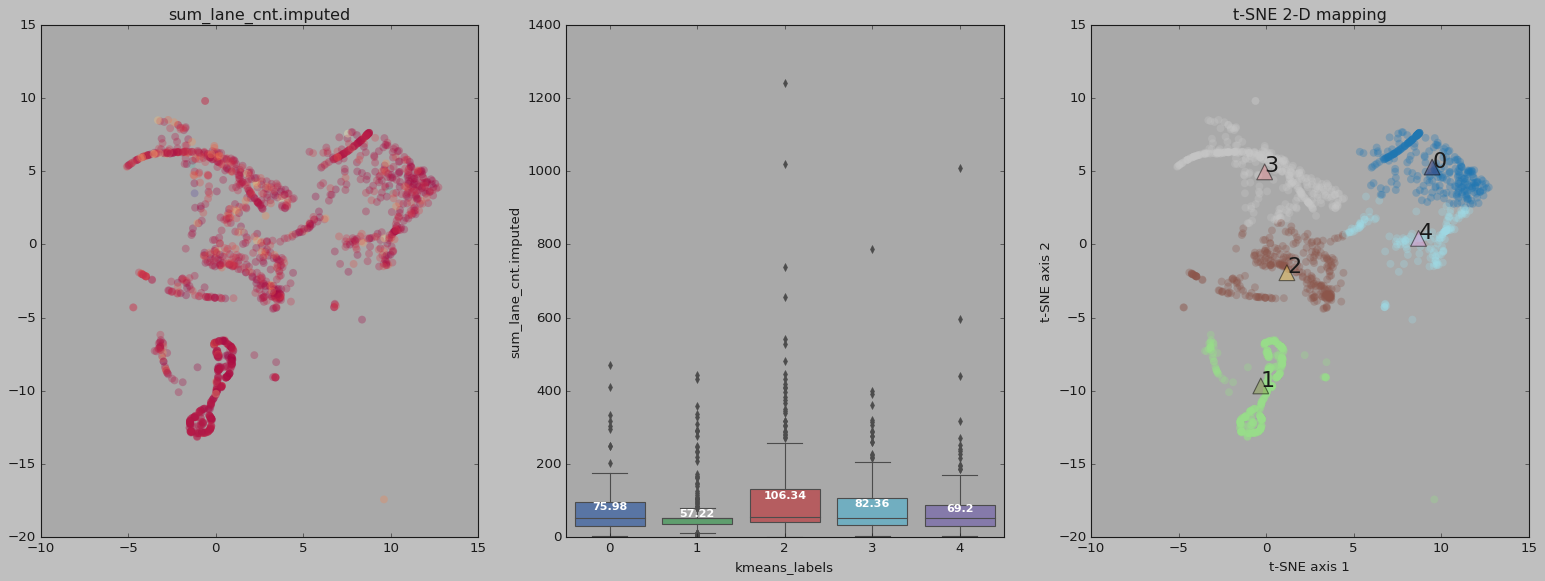

************************** sum_width.imputed
****************************************


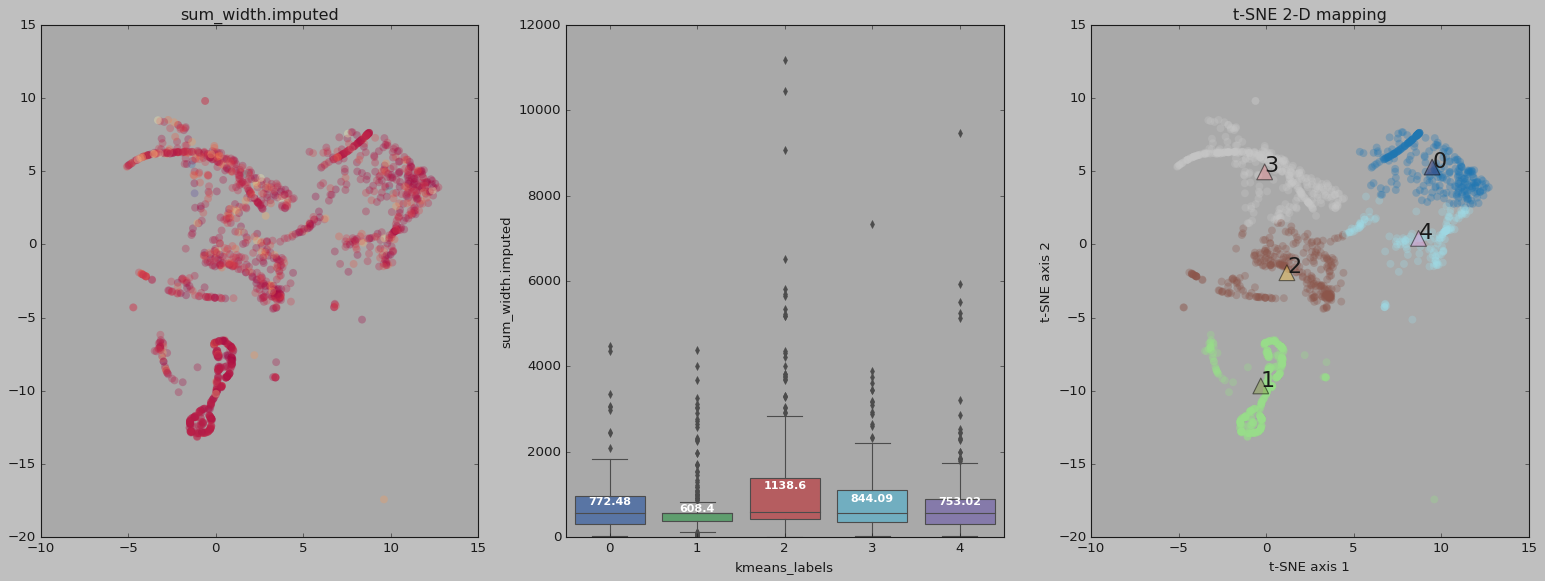

************************** sum_area.imputed
****************************************


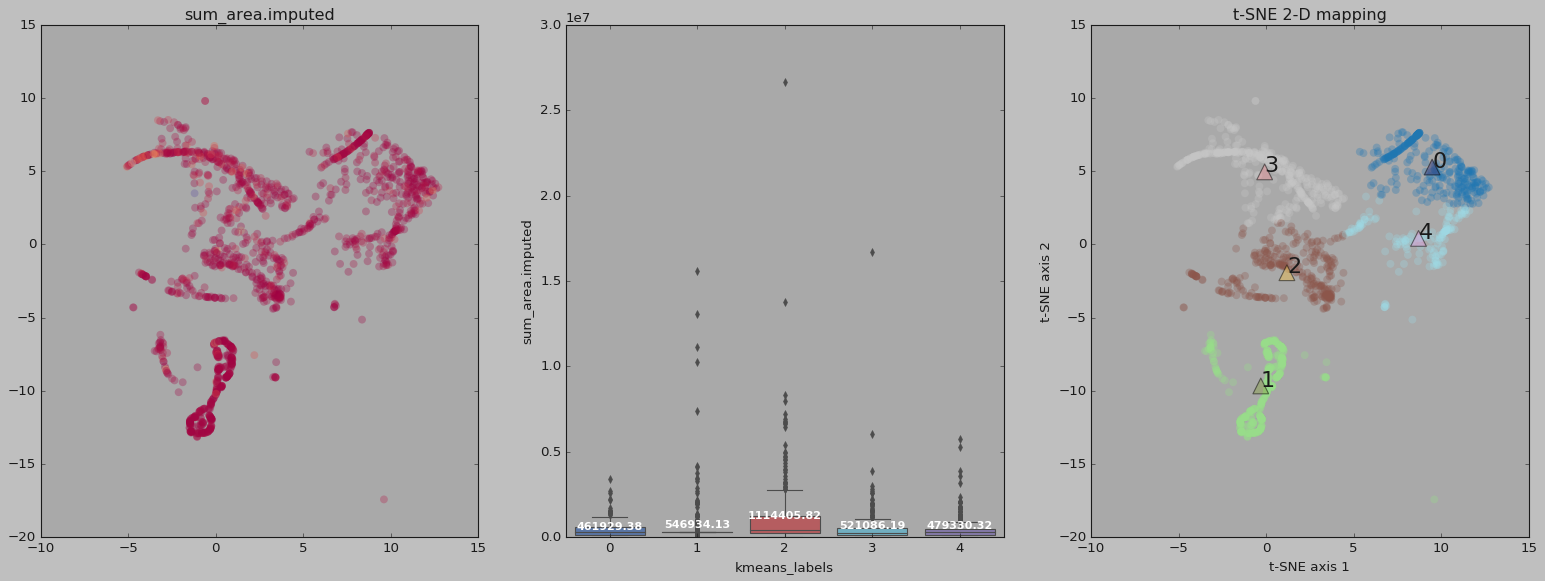

************************** categoryagricultural
****************************************


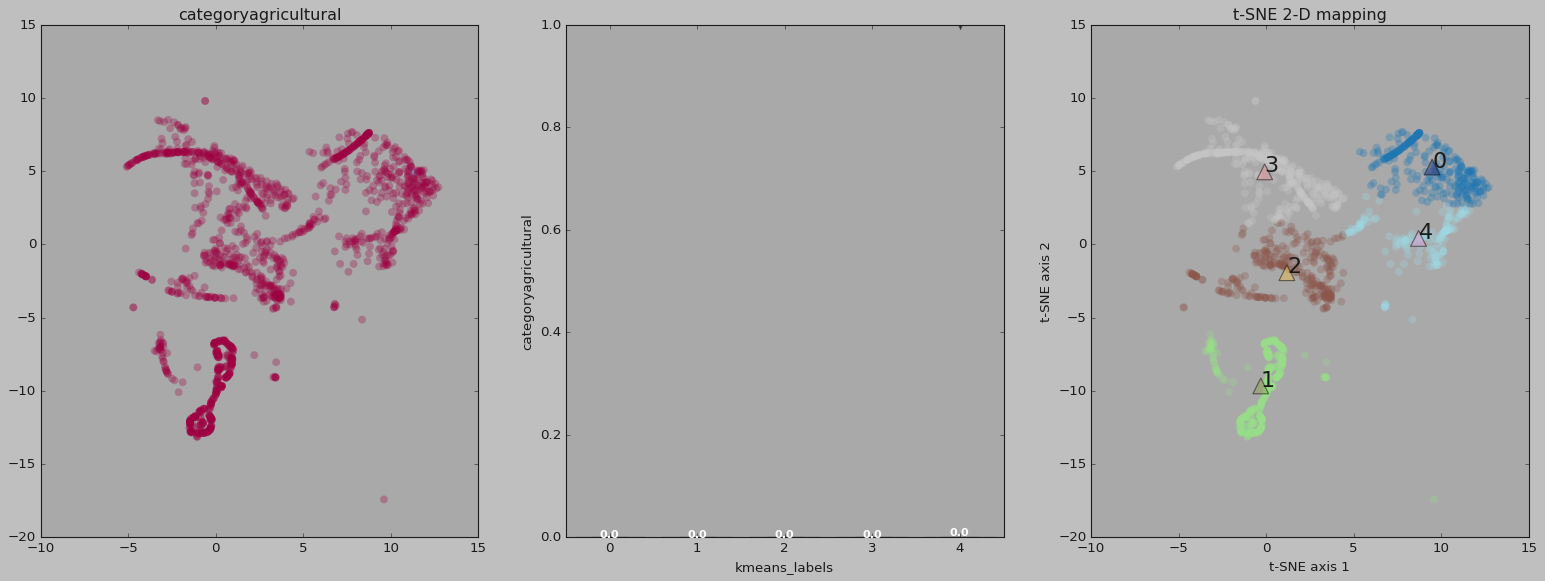

************************** categorycommercial
****************************************


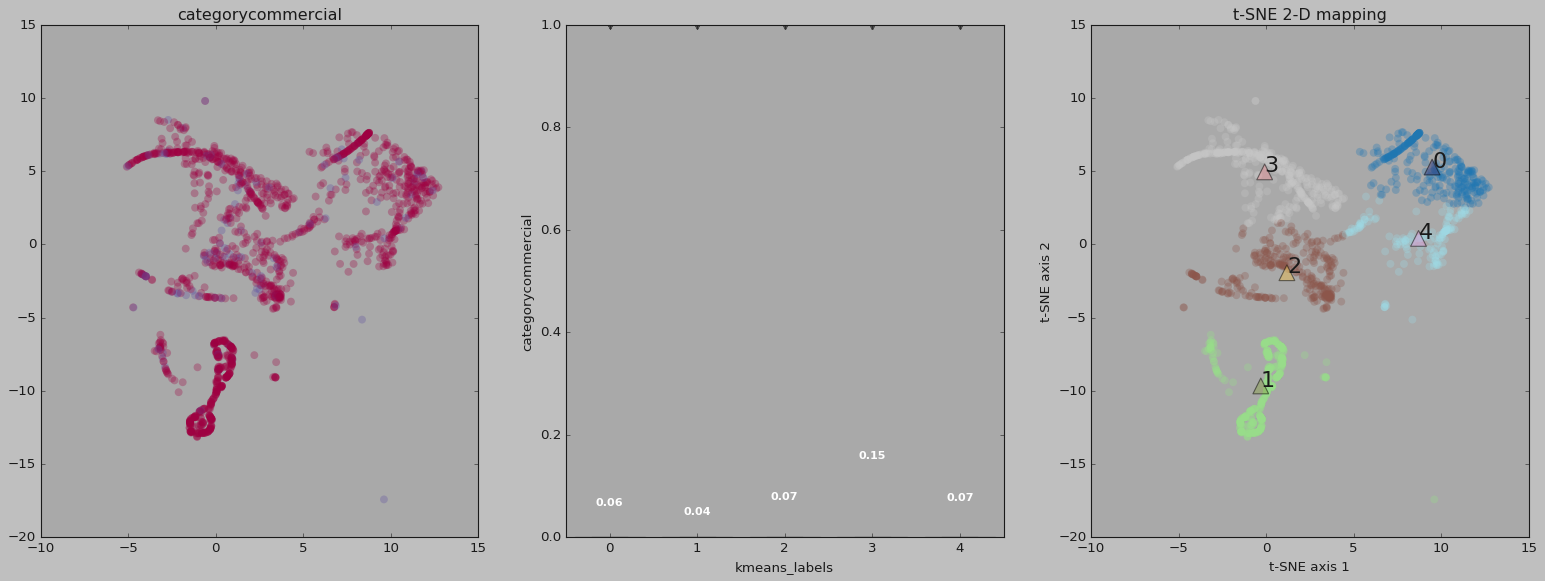

************************** categoryindustrial
****************************************


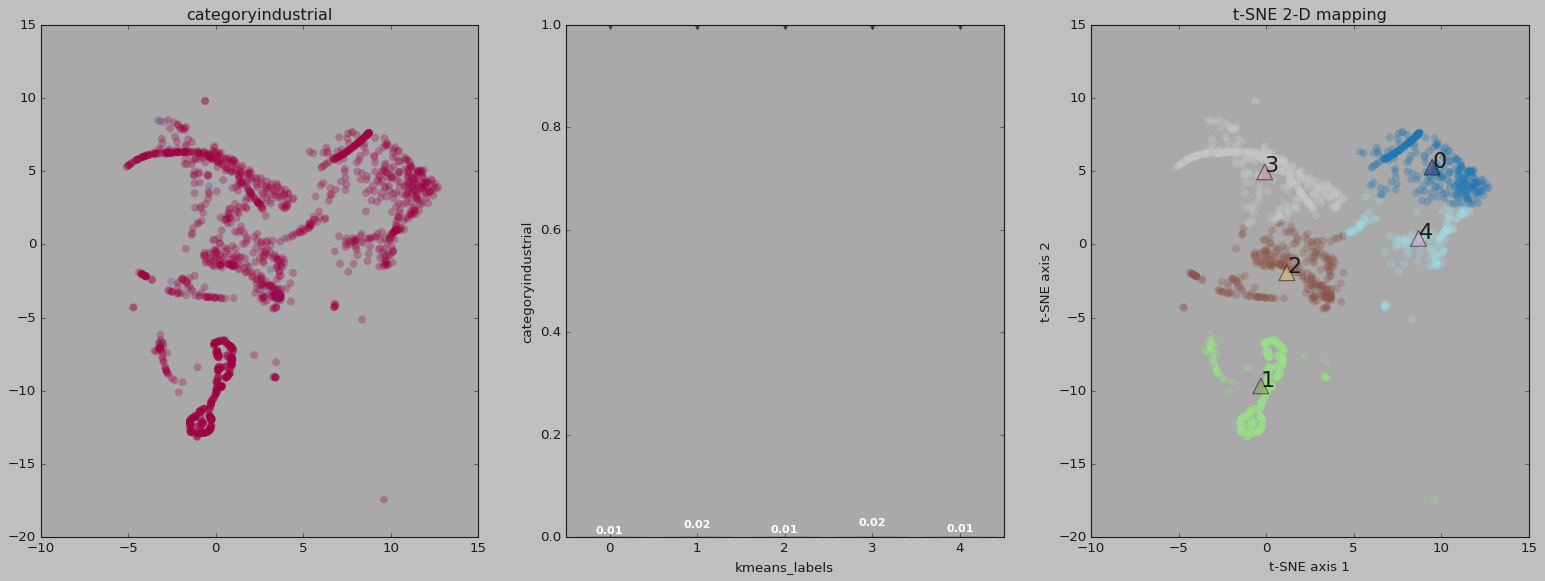

************************** categorypublicly.owned
****************************************


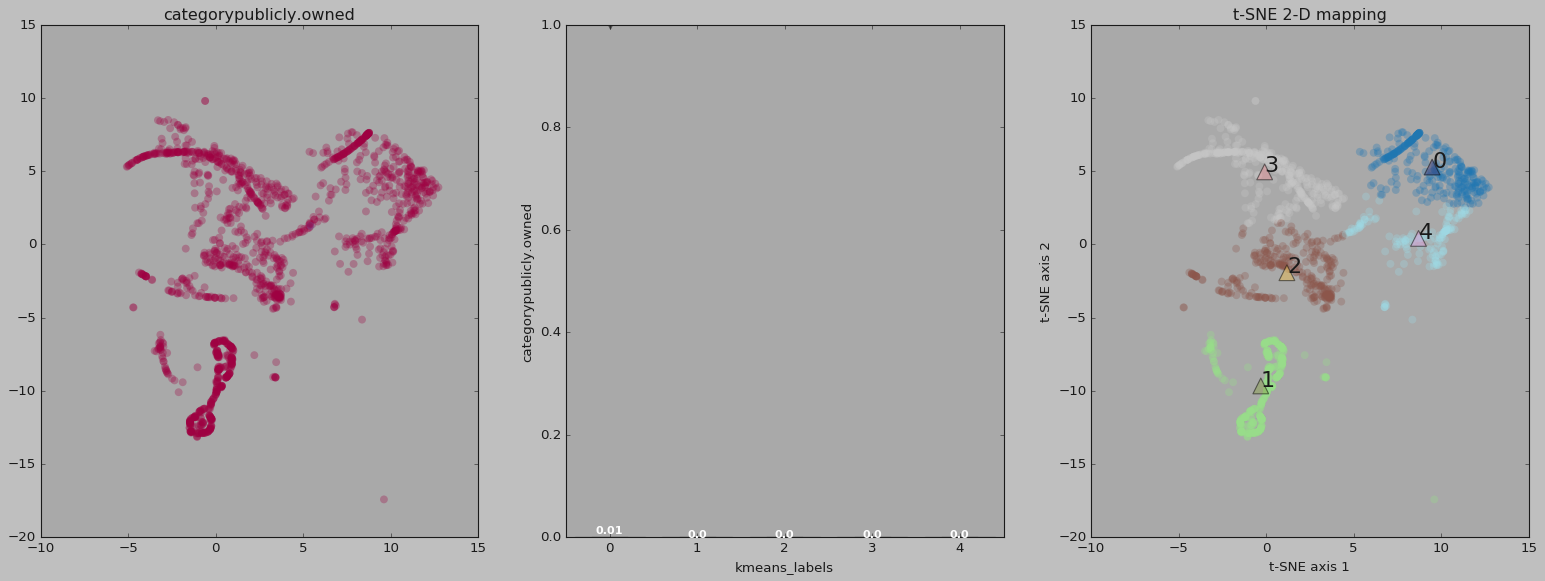

************************** categorypublic.utilities
****************************************


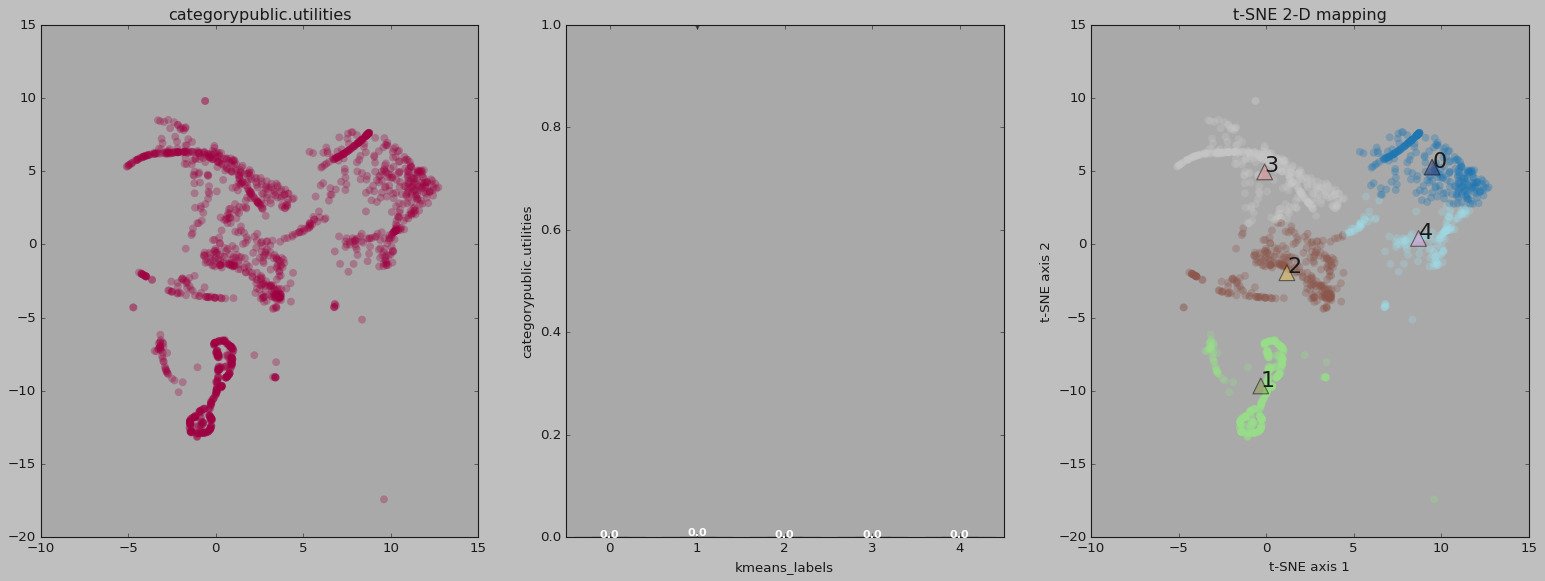

************************** categoryresidential
****************************************


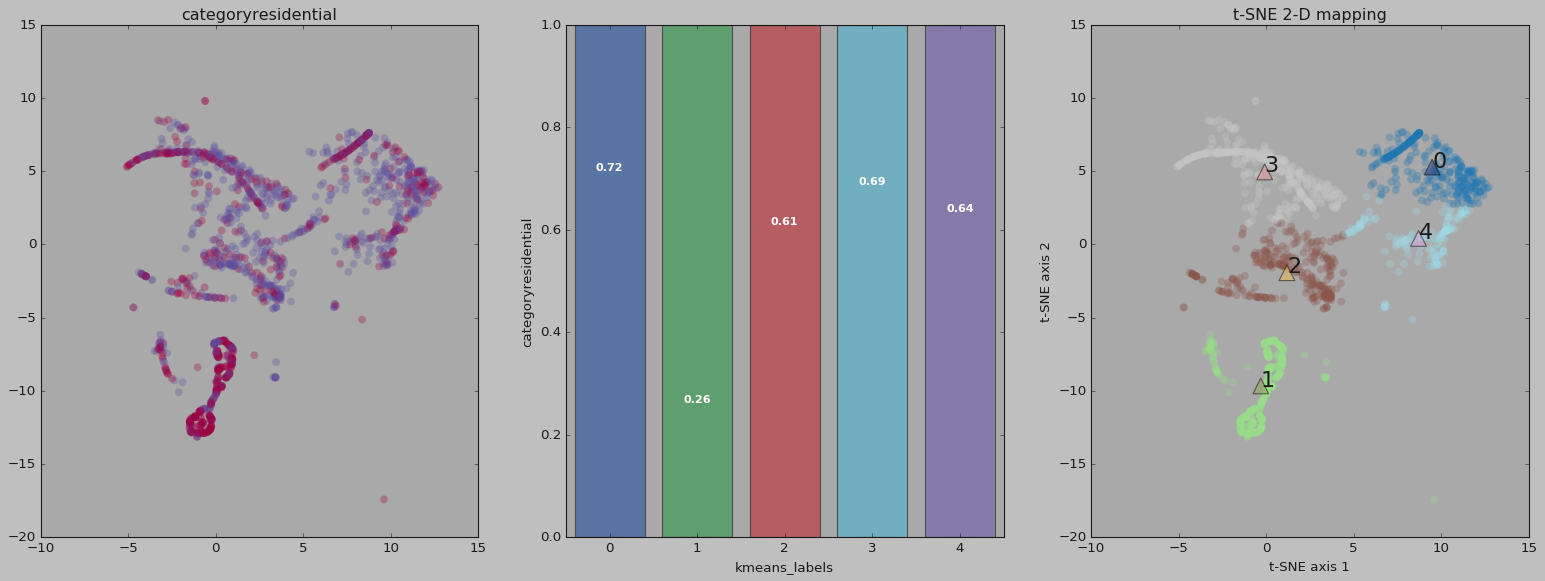

************************** kmeans_labels
****************************************


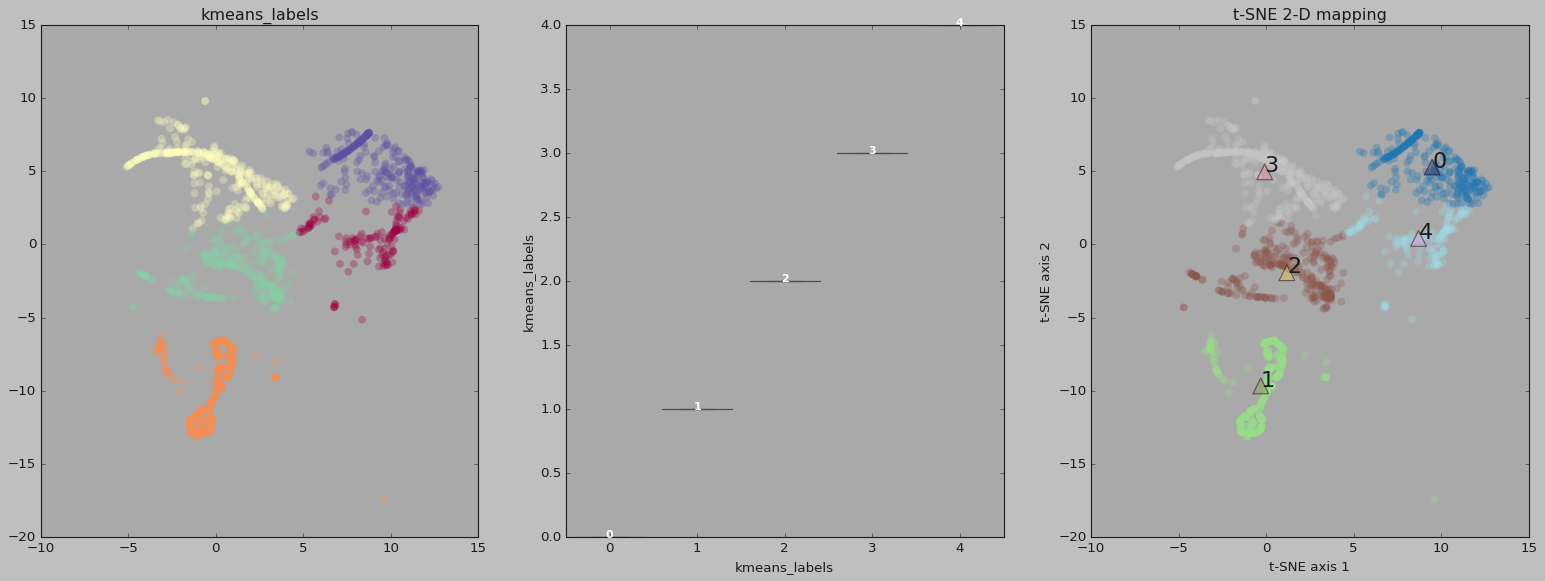

In [290]:

for col in col_names :
    
    _ = plt.figure(figsize=(24, 8));
    print('**************************',col)
# ... feature distribution color map 

    _ = plt.subplot(131, facecolor = 'darkgrey');
    
    _ = plt.scatter(X_all_together['x-tsne'], X_all_together['y-tsne'],
                 c = X_all_together[col],
                 cmap = plt.cm.Spectral,
                 s = 50,
                 linewidths = 0,
                 alpha = 0.30)
    _ = plt.title(col)
    
# ... feature boxplots

    _ = plt.subplot(132, facecolor = 'darkgrey');
    ax = sns.boxplot(x = "kmeans_labels", y = col, data = X_all_together);
    
    
    average_values = X_all_together.groupby(['kmeans_labels'])[col].mean().values
    average_labels = [str(np.round(s, 2)) for s in average_values]

 #   print("****************************************")
#    print(col)
  #  print(average_values)
  #  print(average_labels)
    raw_data = {
    'Column Name':col,
    'cluster 0':average_values[0],
    'cluster 1':average_values[1],
    'cluster 2':average_values[2],
    'cluster 3':average_values[3],
    'cluster 4':average_values[4]
    }

    df_tbl = pd.DataFrame(raw_data,
    columns = ['Column Name','cluster 0','cluster 1','cluster 2','cluster 3','cluster 4'],
    index = [i_index + 1])
    kmeans_weight_tbl = kmeans_weight_tbl.append(df_tbl)    
    print("****************************************")
    pos = range(len(average_values))
    for tick, label in zip(pos, ax.get_xticklabels()):
        
        _ = ax.text(pos[tick], average_values[tick], average_labels[tick], 
                horizontalalignment = 'center', size = 'small', color = 'w', weight = 'semibold')

# ... cluster color map
    
    _ = plt.subplot(133, facecolor = 'darkgrey');
    
    _ = plt.scatter(X_all_together['x-tsne'], X_all_together['y-tsne'],
                 c = kmeans_labels,
                 cmap = plt.cm.tab20,
                 s = 50,
                 linewidths = 0,
                 alpha = 0.30)
    _ = plt.scatter(kmeans_centers[:, 0], kmeans_centers[:, 1],
                c = range(n_lda),
                cmap = plt.cm.tab20b,
                s = 200,
                linewidths = 1.0,
                marker = '^',
                edgecolors = 'black',
                alpha = 0.50);    
    for ii in range(n_lda) :                                       
        _ = plt.text(kmeans_centers[ii, 0], kmeans_centers[ii, 1], ii, fontsize = 20)
        
    _ = plt.xlabel('t-SNE axis 1')
    _ = plt.ylabel('t-SNE axis 2')
    _ = plt.title('t-SNE 2-D mapping')
    
    data_dir = 'C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/'
    data_file_base = "Kmeans_comparison_"
    data_file_num = str(col)
    #data_file_time = datetime.now().strftime("%Y%0m%0d_%H%M%S")
    data_file_time = '18.10.18'
    data_file_ext = ".png"
    plt_file_2_save = data_dir + data_file_base + data_file_num + data_file_time + data_file_ext
    
    plt.savefig(plt_file_2_save)
    _ = plt.show();

In [292]:
kmeans_weight_tbl.reset_index(inplace=True)
kmeans_weight_tbl

index                Column Name      cluster 0      cluster 1  \
0       1              num_fire_incd       0.236486       0.095607   
1       1             num_prop_sales      19.594595       4.638243   
2       1                num_streets      22.986486       8.847545   
3       1            num_walk_scores       0.817568       0.219638   
4       1                num_reports       0.337838       0.100775   
5       1            num_near_misses       0.006757       0.005168   
6       1  median_sale_price.imputed  137080.263514  117602.564599   
7       1     max_sale_price.imputed  716583.391892  425319.612403   
8       1    mean_walk_score.imputed      46.109797      44.265504   
9       1     min_walk_score.imputed      43.939189      42.441860   
10      1     max_walk_score.imputed      48.027027      46.093023   
11      1       sum_lane_cnt.imputed      75.979730      57.222222   
12      1          sum_width.imputed     772.479730     608.397933   
13      1           sum_area.imputed  461929.378378  546934.131783   
14      1       categoryagricultural       0.000000       0.000000   
15      1         categorycommercial       0.060811       0.043928   
16      1         categoryindustrial       0.006757       0.018088   
17      1     categorypublicly.owned       0.006757       0.000000   
18      1   categorypublic.utilities       0.000000       0.002584   
19      1        categoryresidential       0.716216       0.263566   
20      1              kmeans_labels       0.000000       1.000000   

       cluster 2     cluster 3     cluster 4  
0   3.929619e-01  2.909699e-01  3.333333e-01  
1   1.626686e+01  2.755518e+01  2.842517e+01  
2   3.057478e+01  2.726421e+01  2.188435e+01  
3   6.539589e-01  1.110368e+00  7.006803e-01  
4   2.404692e-01  5.317726e-01  4.455782e-01  
5   8.797654e-03  4.682274e-02  3.401361e-03  
6   1.596158e+05  3.238595e+05  1.686669e+05  
7   6.860173e+05  2.034567e+06  1.111616e+06  
8   4.332434e+01  5.093329e+01  4.669779e+01  
9   4.126393e+01  4.849498e+01  4.491156e+01  
10  4.533431e+01  5.308027e+01  4.852041e+01  
11  1.063431e+02  8.236455e+01  6.920408e+01  
12  1.138604e+03  8.440870e+02  7.530204e+02  
13  1.114406e+06  5.210862e+05  4.793303e+05  
14  0.000000e+00  0.000000e+00  3.401361e-03  
15  7.331378e-02  1.538462e-01  7.142857e-02  
16  8.797654e-03  2.341137e-02  1.020408e-02  
17  0.000000e+00  0.000000e+00  0.000000e+00  
18  0.000000e+00  0.000000e+00  0.000000e+00  
19  6.099707e-01  6.889632e-01  6.360544e-01  
20  2.000000e+00  3.000000e+00  4.000000e+00

In [370]:
#for row in kmeans_weight_tbl.iterrows():
sum = kmeans_weight_tbl['cluster 0'] + kmeans_weight_tbl['cluster 1']+ kmeans_weight_tbl['cluster 2'] + kmeans_weight_tbl['cluster 3'] + kmeans_weight_tbl['cluster 4']
kmeans_weight_tbl['Cluster #0'] = (kmeans_weight_tbl['cluster 0']/sum )  * 100
kmeans_weight_tbl['Cluster #1'] = (kmeans_weight_tbl['cluster 1']/sum )  * 100
kmeans_weight_tbl['Cluster #2'] =  (kmeans_weight_tbl['cluster 2']/sum )  * 100
kmeans_weight_tbl['Cluster #3'] = (kmeans_weight_tbl['cluster 3']/sum )  * 100
kmeans_weight_tbl['Cluster #4'] = (kmeans_weight_tbl['cluster 4']/sum )  * 100
print(sum)

0     1.349359e+00
1     9.648005e+01
2     1.115574e+02
3     3.502213e+00
4     1.656433e+00
5     7.094647e-02
6     9.068251e+05
7     4.974103e+06
8     2.313307e+02
9     2.210515e+02
10    2.410550e+02
11    3.911137e+02
12    4.116589e+03
13    3.123686e+06
14    3.401361e-03
15    4.033270e-01
16    6.725772e-02
17    6.756757e-03
18    2.583979e-03
19    2.914770e+00
20    1.000000e+01
dtype: float64


In [334]:
kmeans_weight_tbl.set_index('Column Name')
kmeans_weight_tbl_plot = kmeans_weight_tbl[['Column Name','0_per','1_per','2_per','3_per','4_per']].T

cluster 0      cluster 1     cluster 2  \
Column Name                                                             
num_fire_incd                   0.236486       0.095607  3.929619e-01   
num_prop_sales                 19.594595       4.638243  1.626686e+01   
num_streets                    22.986486       8.847545  3.057478e+01   
num_walk_scores                 0.817568       0.219638  6.539589e-01   
num_reports                     0.337838       0.100775  2.404692e-01   
num_near_misses                 0.006757       0.005168  8.797654e-03   
median_sale_price.imputed  137080.263514  117602.564599  1.596158e+05   
max_sale_price.imputed     716583.391892  425319.612403  6.860173e+05   
mean_walk_score.imputed        46.109797      44.265504  4.332434e+01   
min_walk_score.imputed         43.939189      42.441860  4.126393e+01   
max_walk_score.imputed         48.027027      46.093023  4.533431e+01   
sum_lane_cnt.imputed           75.979730      57.222222  1.063431e+02   
sum_width.imputed             772.479730     608.397933  1.138604e+03   
sum_area.imputed           461929.378378  546934.131783  1.114406e+06   
categoryagricultural            0.000000       0.000000  0.000000e+00   
categorycommercial              0.060811       0.043928  7.331378e-02   
categoryindustrial              0.006757       0.018088  8.797654e-03   
categorypublicly.owned          0.006757       0.000000  0.000000e+00   
categorypublic.utilities        0.000000       0.002584  0.000000e+00   
categoryresidential             0.716216       0.263566  6.099707e-01   
kmeans_labels                   0.000000       1.000000  2.000000e+00   

                              cluster 3     cluster 4       0_per       1_per  \
Column Name                                                                     
num_fire_incd              2.909699e-01  3.333333e-01   17.525841    7.085383   
num_prop_sales             2.755518e+01  2.842517e+01   20.309477    4.807463   
num_streets                2.726421e+01  2.188435e+01   20.605079    7.930937   
num_walk_scores            1.110368e+00  7.006803e-01   23.344314    6.271413   
num_reports                5.317726e-01  4.455782e-01   20.395502    6.083868   
num_near_misses            4.682274e-02  3.401361e-03    9.523739    7.284307   
median_sale_price.imputed  3.238595e+05  1.686669e+05   15.116506   12.968606   
max_sale_price.imputed     2.034567e+06  1.111616e+06   14.406283    8.550679   
mean_walk_score.imputed    5.093329e+01  4.669779e+01   19.932415   19.135161   
min_walk_score.imputed     4.849498e+01  4.491156e+01   19.877352   19.199985   
max_walk_score.imputed     5.308027e+01  4.852041e+01   19.923677   19.121369   
sum_lane_cnt.imputed       8.236455e+01  6.920408e+01   19.426507   14.630585   
sum_width.imputed          8.440870e+02  7.530204e+02   18.765043   14.779176   
sum_area.imputed           5.210862e+05  4.793303e+05   14.787959   17.509255   
categoryagricultural       0.000000e+00  3.401361e-03    0.000000    0.000000   
categorycommercial         1.538462e-01  7.142857e-02   15.077298   10.891324   
categoryindustrial         2.341137e-02  1.020408e-02   10.046069   26.893352   
categorypublicly.owned     0.000000e+00  0.000000e+00  100.000000    0.000000   
categorypublic.utilities   0.000000e+00  0.000000e+00    0.000000  100.000000   
categoryresidential        6.889632e-01  6.360544e-01   24.571960    9.042424   
kmeans_labels              3.000000e+00  4.000000e+00    0.000000   10.000000   

                               2_per      3_per       4_per  
Column Name                                                  
num_fire_incd              29.122118  21.563567   24.703091  
num_prop_sales             16.860337  28.560498   29.462225  
num_streets                27.407223  24.439633   19.617128  
num_walk_scores            18.672735  31.704751   20.006787  
num_reports                14.517291  32.103475   26.899864  
num_near_misses            12.400411  65.997281    4.

In [335]:
kmeans_weight_tbl_plot.rename(columns=kmeans_weight_tbl_plot.iloc[0],inplace=True)
#kmeans_weight_tbl_plot.reset_index(inplace=True)
kmeans_weight_tbl_plot

num_fire_incd  num_prop_sales  num_streets  num_walk_scores  \
Column Name  num_fire_incd  num_prop_sales  num_streets  num_walk_scores   
0_per              17.5258         20.3095      20.6051          23.3443   
1_per              7.08538         4.80746      7.93094          6.27141   
2_per              29.1221         16.8603      27.4072          18.6727   
3_per              21.5636         28.5605      24.4396          31.7048   
4_per              24.7031         29.4622      19.6171          20.0068   

             num_reports  num_near_misses  median_sale_price.imputed  \
Column Name  num_reports  num_near_misses  median_sale_price.imputed   
0_per            20.3955          9.52374                    15.1165   
1_per            6.08387          7.28431                    12.9686   
2_per            14.5173          12.4004                    17.6016   
3_per            32.1035          65.9973                    35.7136   
4_per            26.8999          4.79426                    18.5997   

             max_sale_price.imputed  mean_walk_score.imputed  \
Column Name  max_sale_price.imputed  mean_walk_score.imputed   
0_per                       14.4063                  19.9324   
1_per                       8.55068                  19.1352   
2_per                       13.7918                  18.7283   
3_per                       40.9032                  22.0175   
4_per                       22.3481                  20.1866   

             min_walk_score.imputed      ...        sum_lane_cnt.imputed  \
Column Name  min_walk_score.imputed      ...        sum_lane_cnt.imputed   
0_per                       19.8774      ...                     19.4265   
1_per                          19.2      ...                     14.6306   
2_per                       18.6671      ...                     27.1898   
3_per                       21.9383      ...                      21.059   
4_per                       20.3172      ...                     17.6941   

             sum_width.imputed  sum_area.imputed  categoryagricultural  \
Column Name  sum_width.imputed  sum_area.imputed  categoryagricultural   
0_per                   18.765            14.788                     0   
1_per                  14.7792           17.5093                     0   
2_per                  27.6589            35.676                     0   
3_per                  20.5045           16.6818                     0   
4_per                  18.2923            15.345                   100   

             categorycommercial  categoryindustrial  categorypublicly.owned  \
Column Name  categorycommercial  categoryindustrial  categorypublicly.owned   
0_per                   15.0773             10.0461                     100   
1_per                   10.8913             26.8934                       0   
2_per                   18.1773             13.0805                       0   
3_per                   38.1443             34.8085                       0   
4_per                   17.7098             15.1716                       0   

             categorypublic.utilities  categoryresidential  kmeans_labels  
Column Name  categorypublic.utilities  categoryresidential  kmeans_labels  
0_per                               0               24.572              0  
1_per                             100              9.04242             10  
2_per                               0              20.9269             20  
3_per                               0               23.637             30  
4_per                               0              21.8218             40  

[6 rows x 21 columns]

In [336]:
kmeans_weight_tbl_plot.reset_index(inplace=True)
kmeans_weight_tbl_plot

index  num_fire_incd  num_prop_sales  num_streets  num_walk_scores  \
0  Column Name  num_fire_incd  num_prop_sales  num_streets  num_walk_scores   
1        0_per        17.5258         20.3095      20.6051          23.3443   
2        1_per        7.08538         4.80746      7.93094          6.27141   
3        2_per        29.1221         16.8603      27.4072          18.6727   
4        3_per        21.5636         28.5605      24.4396          31.7048   
5        4_per        24.7031         29.4622      19.6171          20.0068   

   num_reports  num_near_misses  median_sale_price.imputed  \
0  num_reports  num_near_misses  median_sale_price.imputed   
1      20.3955          9.52374                    15.1165   
2      6.08387          7.28431                    12.9686   
3      14.5173          12.4004                    17.6016   
4      32.1035          65.9973                    35.7136   
5      26.8999          4.79426                    18.5997   

   max_sale_price.imputed  mean_walk_score.imputed      ...        \
0  max_sale_price.imputed  mean_walk_score.imputed      ...         
1                 14.4063                  19.9324      ...         
2                 8.55068                  19.1352      ...         
3                 13.7918                  18.7283      ...         
4                 40.9032                  22.0175      ...         
5                 22.3481                  20.1866      ...         

   sum_lane_cnt.imputed  sum_width.imputed  sum_area.imputed  \
0  sum_lane_cnt.imputed  sum_width.imputed  sum_area.imputed   
1               19.4265             18.765            14.788   
2               14.6306            14.7792           17.5093   
3               27.1898            27.6589            35.676   
4                21.059            20.5045           16.6818   
5               17.6941            18.2923            15.345   

   categoryagricultural  categorycommercial  categoryindustrial  \
0  categoryagricultural  categorycommercial  categoryindustrial   
1                     0             15.0773             10.0461   
2                     0             10.8913             26.8934   
3                     0             18.1773             13.0805   
4                     0             38.1443             34.8085   
5                   100             17.7098             15.1716   

   categorypublicly.owned  categorypublic.utilities  categoryresidential  \
0  categorypublicly.owned  categorypublic.utilities  categoryresidential   
1                     100                         0               24.572   
2                       0                       100              9.04242   
3                       0                         0              20.9269   
4                       0                         0               23.637   
5                       0                         0              21.8218   

   kmeans_labels  
0  kmeans_labels  
1              0  
2             10  
3             20  
4             30  
5             40  

[6 rows x 22 columns]

In [340]:
kmeans_weight_tbl_plot = kmeans_weight_tbl_plot[1:6]

In [363]:
kmeans_weight_tbl

Column Name      cluster 0      cluster 1     cluster 2  \
0               num_fire_incd       0.236486       0.095607  3.929619e-01   
1              num_prop_sales      19.594595       4.638243  1.626686e+01   
2                 num_streets      22.986486       8.847545  3.057478e+01   
3             num_walk_scores       0.817568       0.219638  6.539589e-01   
4                 num_reports       0.337838       0.100775  2.404692e-01   
5             num_near_misses       0.006757       0.005168  8.797654e-03   
6   median_sale_price.imputed  137080.263514  117602.564599  1.596158e+05   
7      max_sale_price.imputed  716583.391892  425319.612403  6.860173e+05   
8     mean_walk_score.imputed      46.109797      44.265504  4.332434e+01   
9      min_walk_score.imputed      43.939189      42.441860  4.126393e+01   
10     max_walk_score.imputed      48.027027      46.093023  4.533431e+01   
11       sum_lane_cnt.imputed      75.979730      57.222222  1.063431e+02   
12          sum_width.imputed     772.479730     608.397933  1.138604e+03   
13           sum_area.imputed  461929.378378  546934.131783  1.114406e+06   
14       categoryagricultural       0.000000       0.000000  0.000000e+00   
15         categorycommercial       0.060811       0.043928  7.331378e-02   
16         categoryindustrial       0.006757       0.018088  8.797654e-03   
17     categorypublicly.owned       0.006757       0.000000  0.000000e+00   
18   categorypublic.utilities       0.000000       0.002584  0.000000e+00   
19        categoryresidential       0.716216       0.263566  6.099707e-01   
20              kmeans_labels       0.000000       1.000000  2.000000e+00   

       cluster 3     cluster 4       0_per       1_per      2_per      3_per  \
0   2.909699e-01  3.333333e-01   17.525841    7.085383  29.122118  21.563567   
1   2.755518e+01  2.842517e+01   20.309477    4.807463  16.860337  28.560498   
2   2.726421e+01  2.188435e+01   20.605079    7.930937  27.407223  24.439633   
3   1.110368e+00  7.006803e-01   23.344314    6.271413  18.672735  31.704751   
4   5.317726e-01  4.455782e-01   20.395502    6.083868  14.517291  32.103475   
5   4.682274e-02  3.401361e-03    9.523739    7.284307  12.400411  65.997281   
6   3.238595e+05  1.686669e+05   15.116506   12.968606  17.601612  35.713554   
7   2.034567e+06  1.111616e+06   14.406283    8.550679  13.791778  40.903182   
8   5.093329e+01  4.669779e+01   19.932415   19.135161  18.728313  22.017519   
9   4.849498e+01  4.491156e+01   19.877352   19.199985  18.667109  21.938316   
10  5.308027e+01  4.852041e+01   19.923677   19.121369  18.806623  22.019979   
11  8.236455e+01  6.920408e+01   19.426507   14.630585  27.189820  21.058979   
12  8.440870e+02  7.530204e+02   18.765043   14.779176  27.658920  20.504523   
13  5.210862e+05  4.793303e+05   14.787959   17.509255  35.675989  16.681773   
14  0.000000e+00  3.401361e-03    0.000000    0.000000   0.000000   0.000000   
15  1.538462e-01  7.142857e-02   15.077298   10.891324  18.177258  38.144277   
16  2.341137e-02  1.020408e-02   10.046069   26.893352  13.080512  34.808453   
17  0.000000e+00  0.000000e+00  100.000000    0.000000   0.000000   0.000000   
18  0.000000e+00  0.000000e+00    0.000000  100.000000   0.000000   0.000000   
19  6.889632e-01  6.360544e-01   24.571960    9.042424  20.926886  23.636963   
20  3.000000e+00  4.000000e+00    0.000000   10.000000  20.000000  30.000000   

         4_per  
0    24.703091  
1    29.462225  
2    19.617128  
3    20.006787  
4    26.899864  
5     4.794263  
6    18.599722  
7    22.348078  
8    20.186593  
9    20.317238  
10   20.128353  
11   17.694109  
12   18.292338  
13   15.345023  
14  100.000000  
15   17.709843  
16   15.171614  
17    0.000000  
18    0.000000  
19   21.821767  
20   40.000000

In [371]:
kmeans_cols = ['Cluster #0', 'Cluster #1', 'Cluster #2', 'Cluster #3', 'Cluster #4']
kmeans_cols

['Cluster #0', 'Cluster #1', 'Cluster #2', 'Cluster #3', 'Cluster #4']

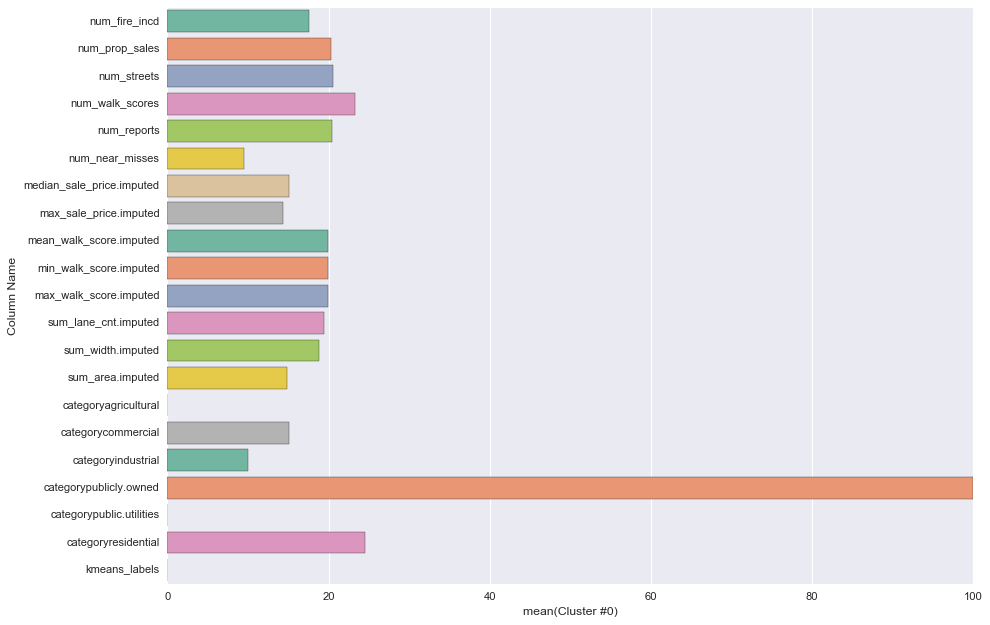

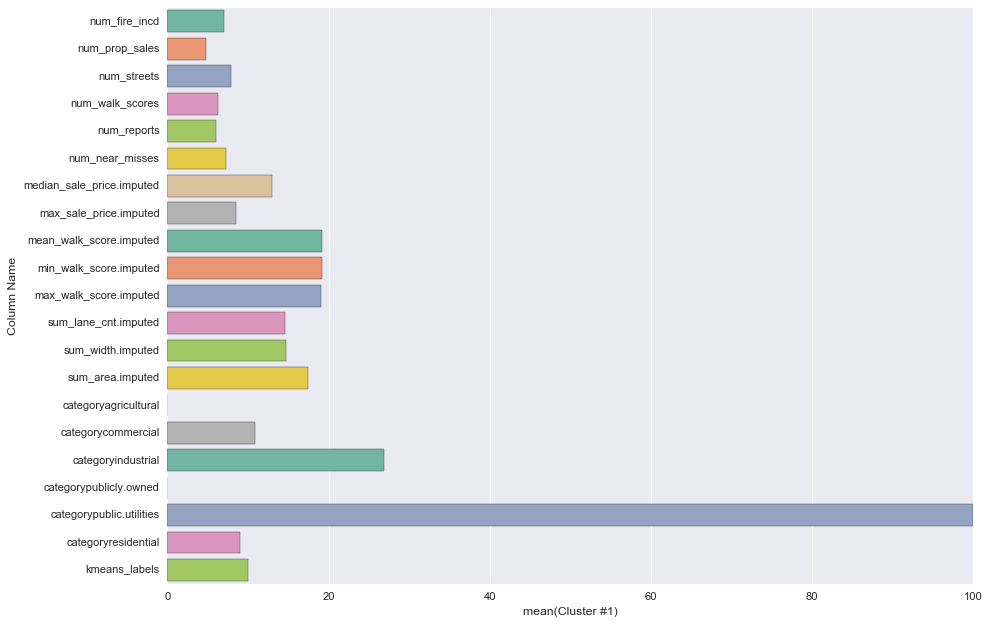

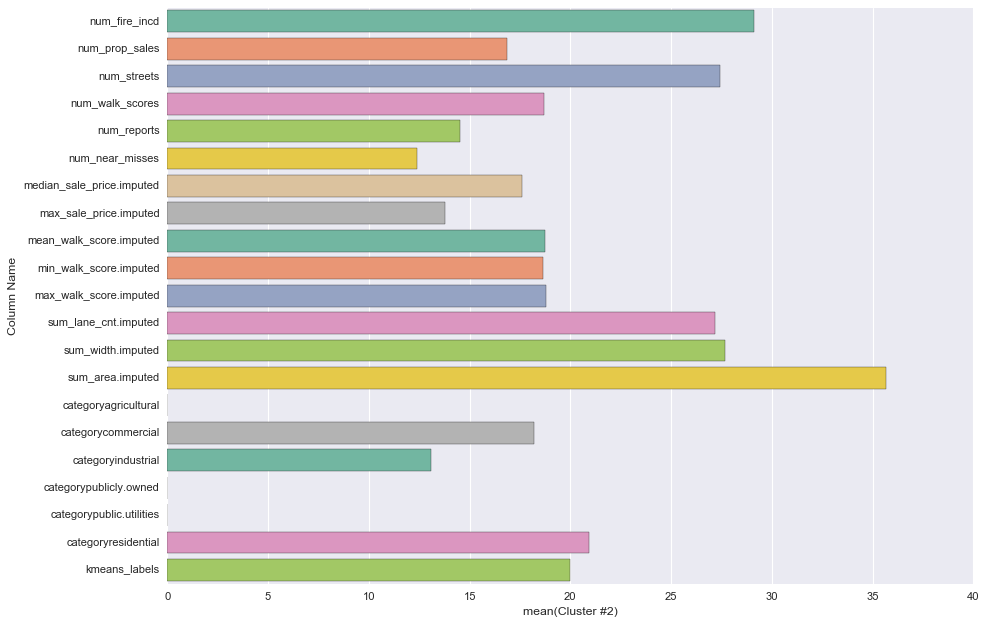

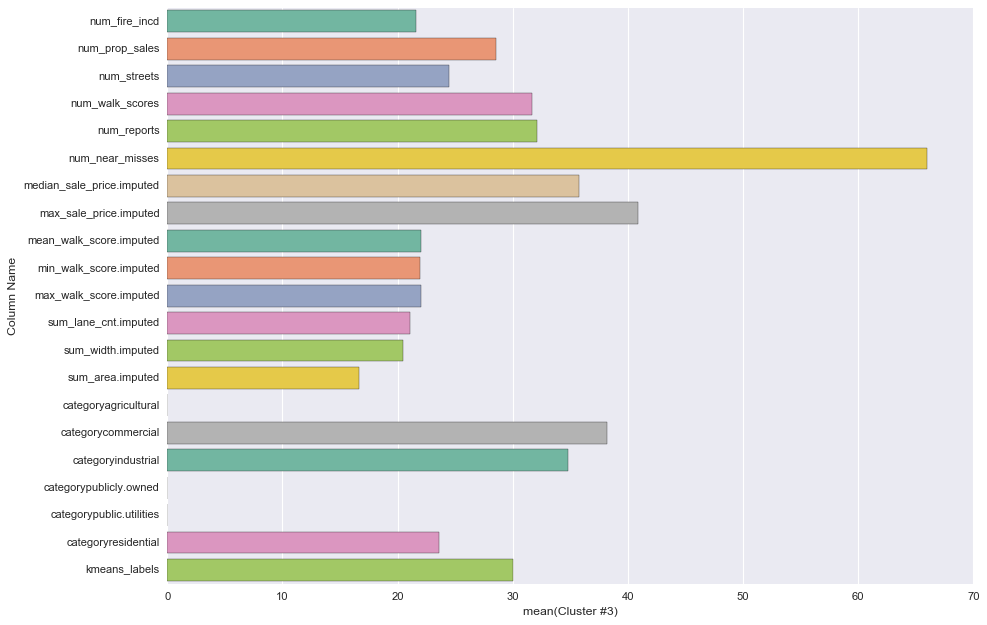

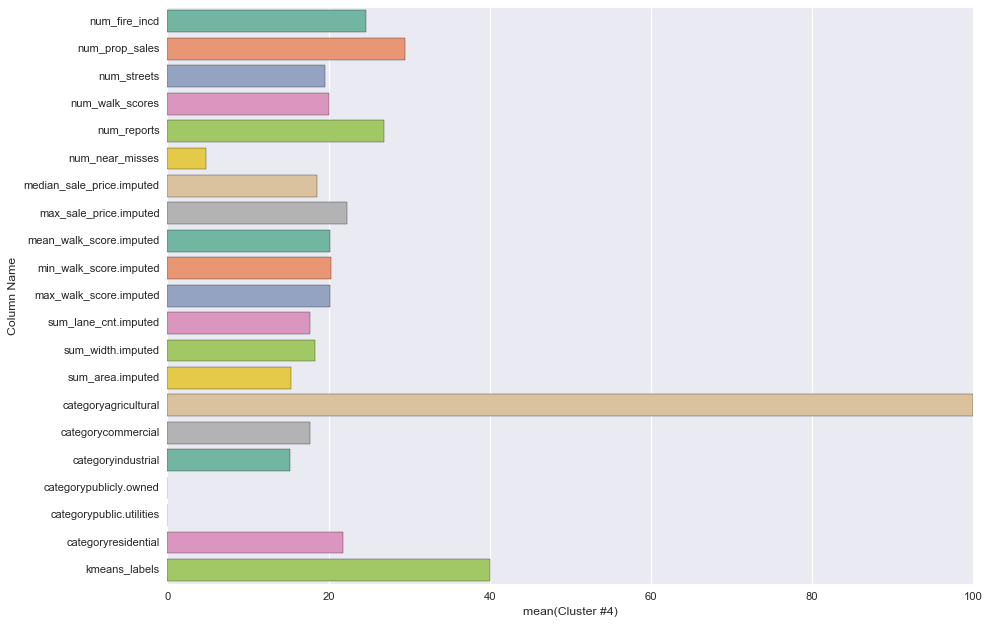

In [372]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(13,9)})
for col in kmeans_cols:
    #sns.boxplot(y=col, x="index", data=kmeans_weight_tbl_plot,palette='rainbow')
    sns.barplot(y="Column Name", x=col, data=kmeans_weight_tbl,palette='Set2')
    #sns.barplot(x='sex',y='total_bill',data=tips)
    data_dir = 'C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/'
    data_file_base = "Kmeans_cluster_"
    data_file_num = str(col)
    #data_file_time = datetime.now().strftime("%Y%0m%0d_%H%M%S")
    data_file_time = '18.10.18'
    data_file_ext = ".png"
    plt_file_2_save = data_dir + data_file_base + data_file_num + data_file_time + data_file_ext
    plt.savefig(plt_file_2_save)
    plt.show()

### Hierachical Clustering

In [128]:
# set required variables for model comparison

comparison_tbl = pd.DataFrame(columns = [
    'model_name',
    'n_clusters',
    'inertia',
    'silhouette',
    'process_time'])

i_index = []
i_index = 0

# preparation for cross validation and model comparison, each classifier is appended once model is fit

models = []

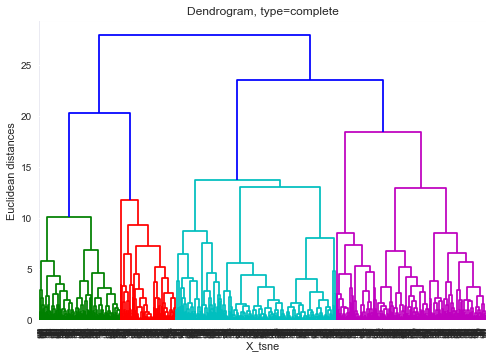

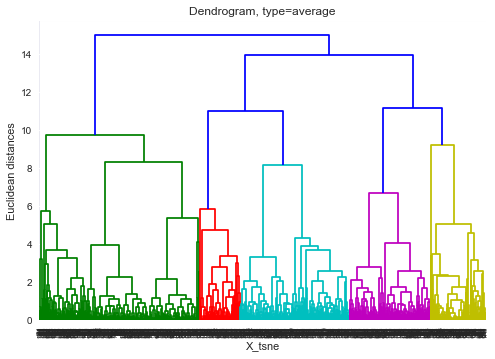

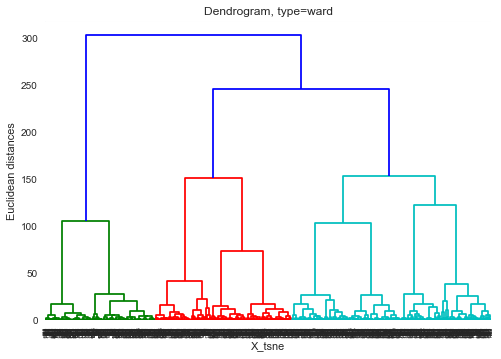

In [129]:
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(X_tsne, method = 'complete'))
_ = plt.title('Dendrogram, type=complete')
_ = plt.xlabel('X_tsne')
_ = plt.ylabel('Euclidean distances')
plt.savefig("C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/hierarchical/dendrogram_complete.png")
_ = plt.show()


# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(X_tsne, method = 'average'))
_ = plt.title('Dendrogram, type=average')
_ = plt.xlabel('X_tsne')
_ = plt.ylabel('Euclidean distances')
plt.savefig("C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/hierarchical/dendrogram_average.png")
_ = plt.show()


# Using the dendrogram to find the optimal number of clusters
dendrogram = sch.dendrogram(sch.linkage(X_tsne, method = 'ward'))
_ = plt.title('Dendrogram, type=ward')
_ = plt.xlabel('X_tsne')
_ = plt.ylabel('Euclidean distances')
plt.savefig("C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/hierarchical/dendrogram_ward.png")
_ = plt.show()

In [130]:
n_optimal_cluster_ward = 3
n_optimal_cluster_average = 5
n_optimal_cluster_complete = 4

In [131]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... optimal models for linkage = ward
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

tic = time.clock()
hc_ward = AgglomerativeClustering(n_clusters = n_optimal_cluster_ward, affinity = 'euclidean', linkage = 'ward')
hc_ward.fit(X_tsne)

hc_labels_ward = hc_ward.labels_ # the labels from hierarchical clustering
#hc_centers = hc_lda.cluster_centers_

# hc_inertia = hc_lda.inertia_
#print ("inertia = ", hc_inertia)

hc_silhouette = metrics.silhouette_score(X_tsne,
                                             hc_labels_ward,
                                             metric = 'euclidean',
                                             sample_size = 10000)
print ("silhouette = ", hc_silhouette)

toc =  time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - save statistics for model comparison
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

exe_time = '{0:.4f}'.format(toc-tic)

raw_data = {
'model_name' : 'hierarchical - ward',
'n_clusters' : n_optimal_cluster_ward,
'inertia': 'NA',
'silhouette': hc_silhouette, 
'process_time' : exe_time
}

df_tbl = pd.DataFrame(raw_data,
columns = ['model_name', 'n_clusters', 'inertia', 'silhouette', 'process_time'],
index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=3,
            pooling_func=<function mean at 0x0000026421B34378>)

silhouette =  0.42414387867552295


In [132]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... optimal models for linkage = complete, #of clusters = 3
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

tic = time.clock()
hc_complete = AgglomerativeClustering(n_clusters = n_optimal_cluster_complete, affinity = 'euclidean', linkage = 'complete')
hc_complete.fit(X_tsne)

hc_labels_complete = hc_complete.labels_ # the labels from hierarchical clustering
#hc_centers = hc_lda.cluster_centers_

# hc_inertia = hc_lda.inertia_
#print ("inertia = ", hc_inertia)

hc_silhouette = metrics.silhouette_score(X_tsne,
                                             hc_labels_complete,
                                             metric = 'euclidean',
                                             sample_size = 10000)
print ("silhouette = ", hc_silhouette)

toc =  time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - save statistics for model comparison
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

exe_time = '{0:.4f}'.format(toc-tic)

raw_data = {
'model_name' : 'hierarchical - complete',
'n_clusters' : n_optimal_cluster_complete,
'inertia': 'NA',
'silhouette': hc_silhouette, 
'process_time' : exe_time
}

df_tbl = pd.DataFrame(raw_data,
columns = ['model_name', 'n_clusters', 'inertia', 'silhouette', 'process_time'],
index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='complete',
            memory=Memory(cachedir=None), n_clusters=4,
            pooling_func=<function mean at 0x0000026421B34378>)

silhouette =  0.4809951829888892


In [133]:
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... optimal models for linkage = average #of clusters = 4
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

tic = time.clock()
hc_average = AgglomerativeClustering(n_clusters = n_optimal_cluster_average, affinity = 'euclidean', linkage = 'average')
hc_average.fit(X_tsne)

hc_labels_average = hc_average.labels_ # the labels from hierarchical clustering
#hc_centers = hc_lda.cluster_centers_

# hc_inertia = hc_lda.inertia_
#print ("inertia = ", hc_inertia)

hc_silhouette = metrics.silhouette_score(X_tsne,
                                             hc_labels_average,
                                             metric = 'euclidean',
                                             sample_size = 10000)
print ("silhouette = ", hc_silhouette)

toc =  time.clock()

# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
# ... - save statistics for model comparison
# ... -=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

exe_time = '{0:.4f}'.format(toc-tic)

raw_data = {
'model_name' : 'hierarchical - average',
'n_clusters' : n_optimal_cluster_average,
'inertia': 'NA',
'silhouette': hc_silhouette, 
'process_time' : exe_time
}

df_tbl = pd.DataFrame(raw_data,
columns = ['model_name', 'n_clusters', 'inertia', 'silhouette', 'process_time'],
index = [i_index + 1])

comparison_tbl = comparison_tbl.append(df_tbl)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=5,
            pooling_func=<function mean at 0x0000026421B34378>)

silhouette =  0.520063661069125


In [134]:
comparison_tbl = comparison_tbl.reset_index(drop=True)
comparison_tbl['process_time'] = pd.to_numeric(comparison_tbl['process_time'])
comparison_tbl

model_name n_clusters inertia  silhouette  process_time
0      hierarchical - ward          3      NA    0.424144        0.1579
1  hierarchical - complete          4      NA    0.480995        0.1529
2   hierarchical - average          5      NA    0.520064        0.1514

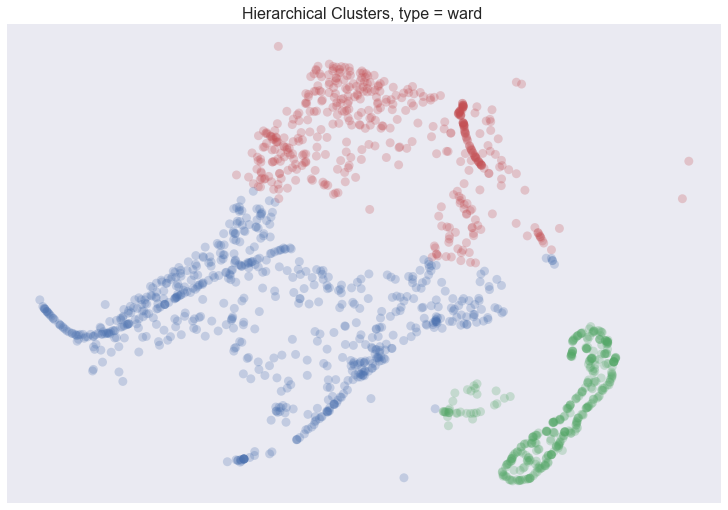

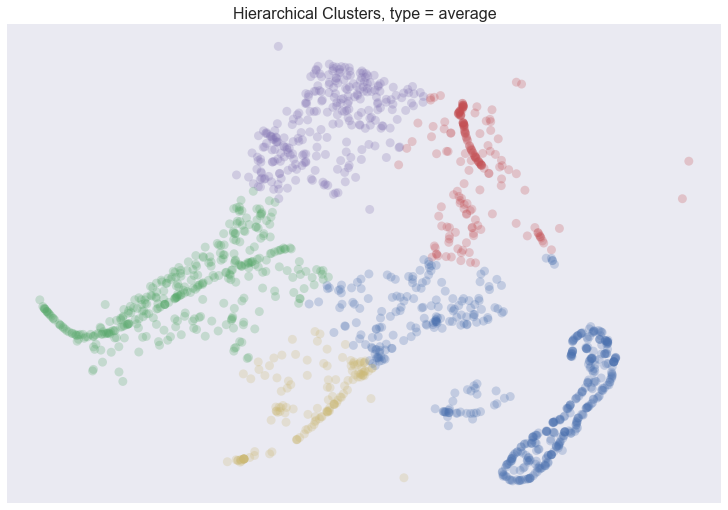

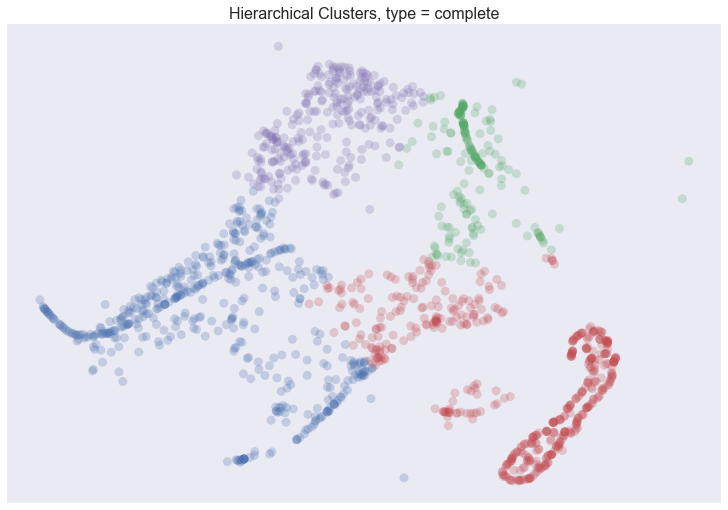

In [135]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}


palette = sns.color_palette('deep', np.unique(hc_labels_ward).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in hc_labels_ward]
X_tsne_values = X_tsne.values;
_= plt.scatter(X_tsne_values[:, 0], X_tsne_values[:, 1], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
_= plt.title('Hierarchical Clusters, type = ward ' , fontsize=16)
_ = plt.xlabel("X_tsne");
_ = plt.ylabel("y_tsne");
plt.savefig("C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/hierarchical/hc_ward_eval.png")
_=plt.show()

palette = sns.color_palette('deep', np.unique(hc_labels_average).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in hc_labels_average]
X_tsne_values = X_tsne.values;
_= plt.scatter(X_tsne_values[:, 0], X_tsne_values[:, 1], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
_= plt.title('Hierarchical Clusters, type = average' , fontsize=16)
plt.savefig("C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/hierarchical/hc_average_eval.png")
_=plt.show()

palette = sns.color_palette('deep', np.unique(hc_labels_complete).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in hc_labels_complete]
X_tsne_values = X_tsne.values;
_= plt.scatter(X_tsne_values[:, 0], X_tsne_values[:, 1], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
_= plt.title('Hierarchical Clusters, type = complete' , fontsize=16)
plt.savefig("C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/hierarchical/hc_complete_eval.png")
_=plt.show()


In [137]:
X_all_together['hierarchical'] = hc_labels_average

In [140]:
hc_labels_average

array([1, 1, 4, ..., 0, 3, 0], dtype=int64)

In [143]:
hc_average_centers_x = X_all_together.groupby(['hierarchical'])['x-tsne'].mean()
hc_average_centers_y= X_all_together.groupby(['hierarchical'])['y-tsne'].mean()
hc_average_centers_x
hc_average_centers_y
n_lda = np.unique(hc_labels_average).max() +1
n_lda

#### feature importance for complete method

X_HC_average_analysis = copy.deepcopy(X_all_together)
del X_HC_average_analysis['x-tsne']
del X_HC_average_analysis['y-tsne']
#del X_HC_average_analysis['sample_index']

grouped = X_HC_average_analysis.groupby(['hierarchical'])
#print(grouped)

X_HC_average_analysis = (grouped.mean() - X_HC_average_analysis.mean()) / X_HC_average_analysis.std()

#HC_Complete_analysis_tbl

hierarchical
0    11.392387
1    -1.557203
2     9.823427
3     4.045088
4     3.374132
Name: x-tsne, dtype: float64

hierarchical
0   -4.173043
1    0.038336
2    6.035968
3    8.176941
4   -5.293460
Name: y-tsne, dtype: float64

5

*************************  x-tsne


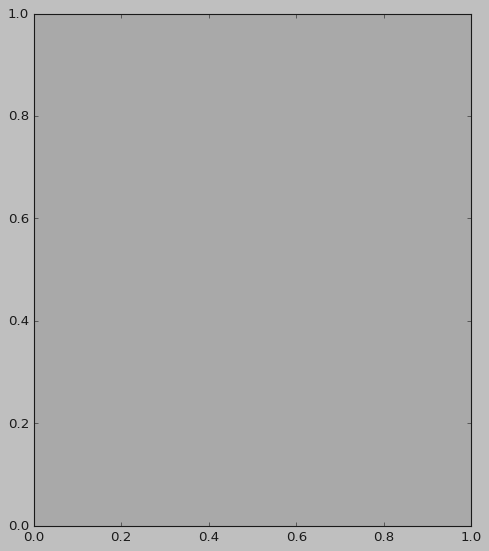

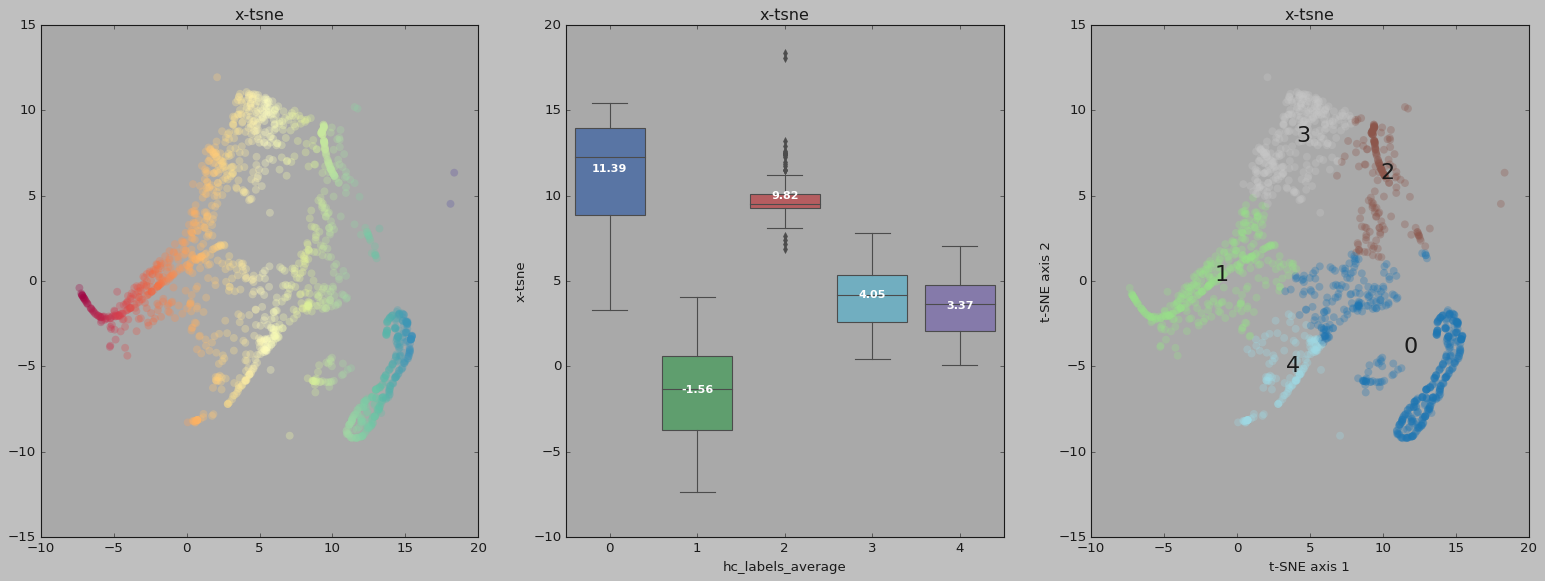

*************************  y-tsne


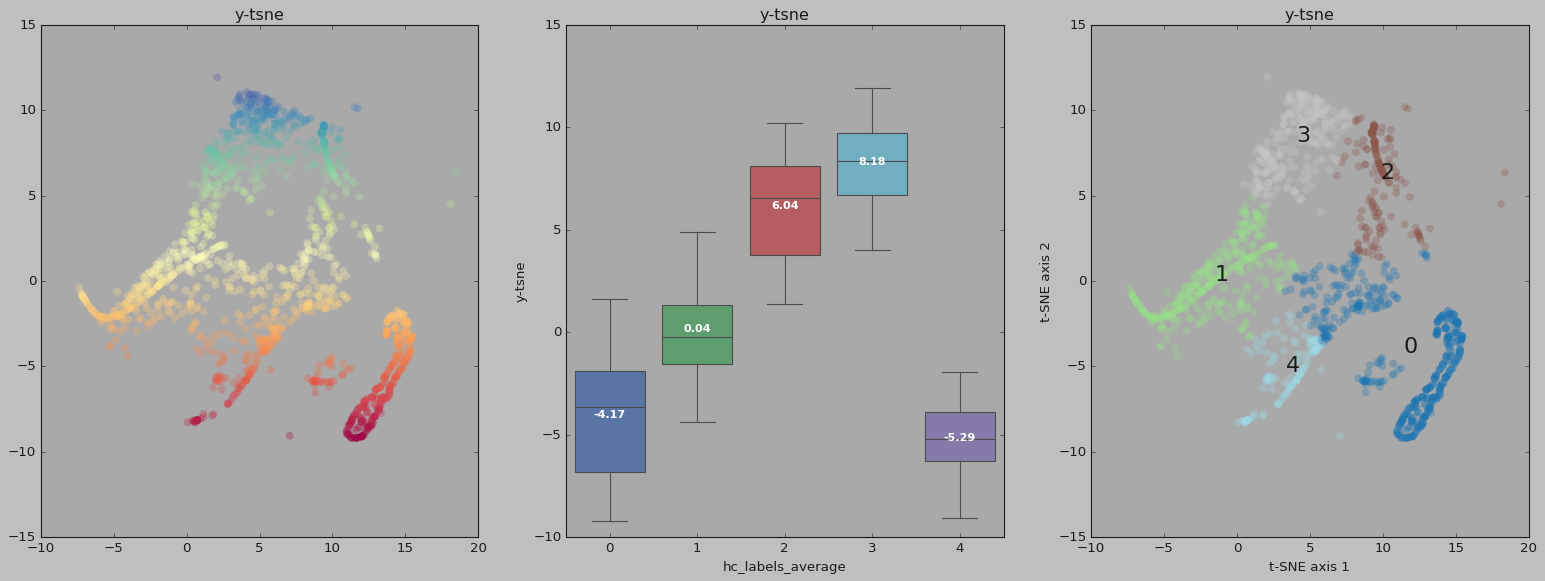

*************************  cell_id


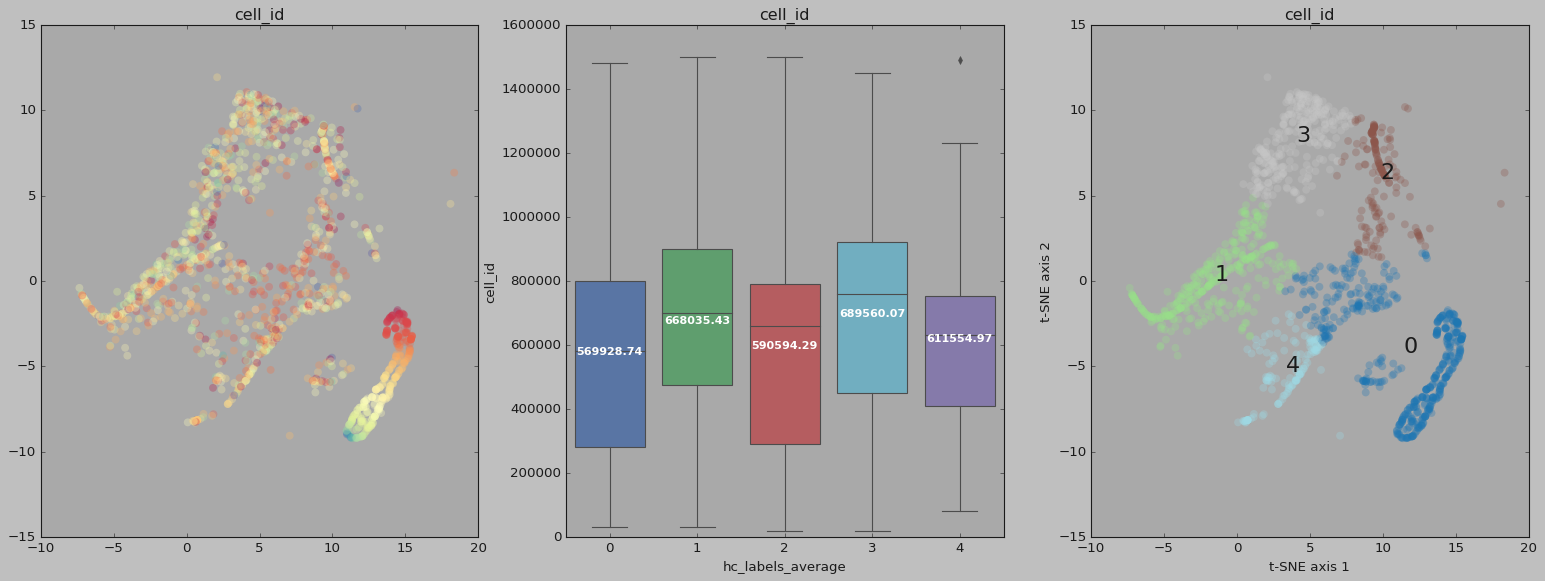

*************************  lat


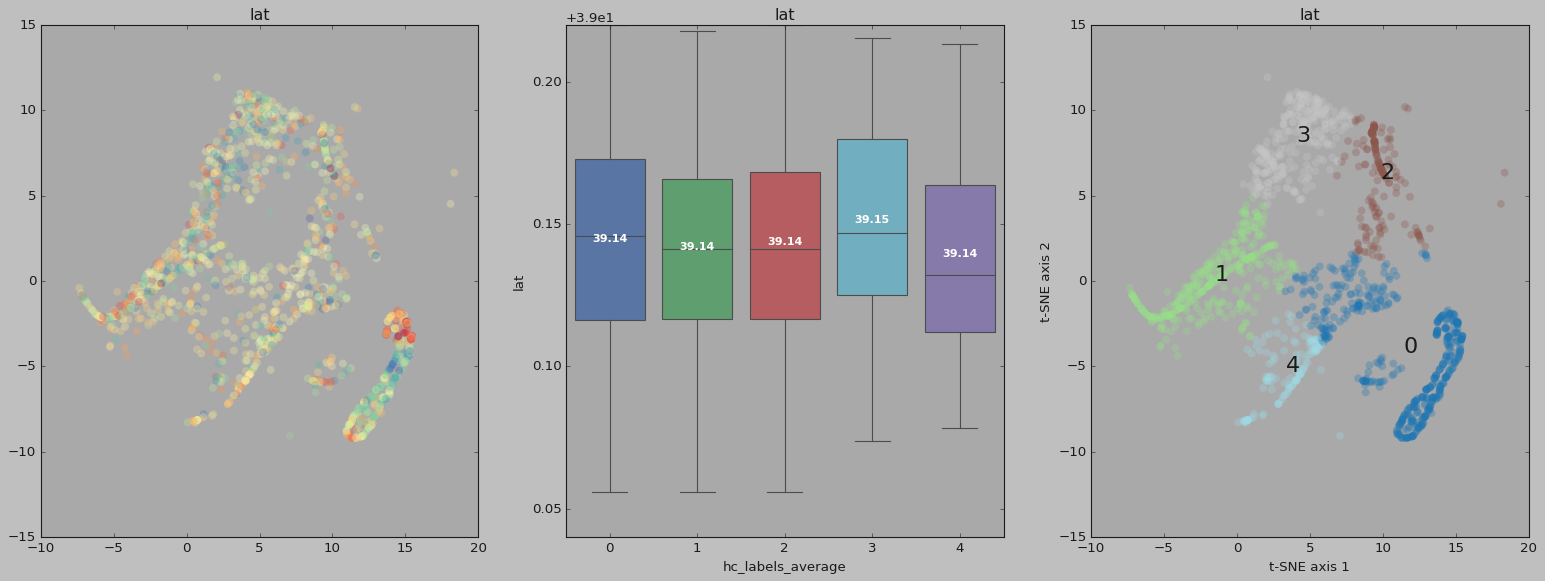

*************************  long


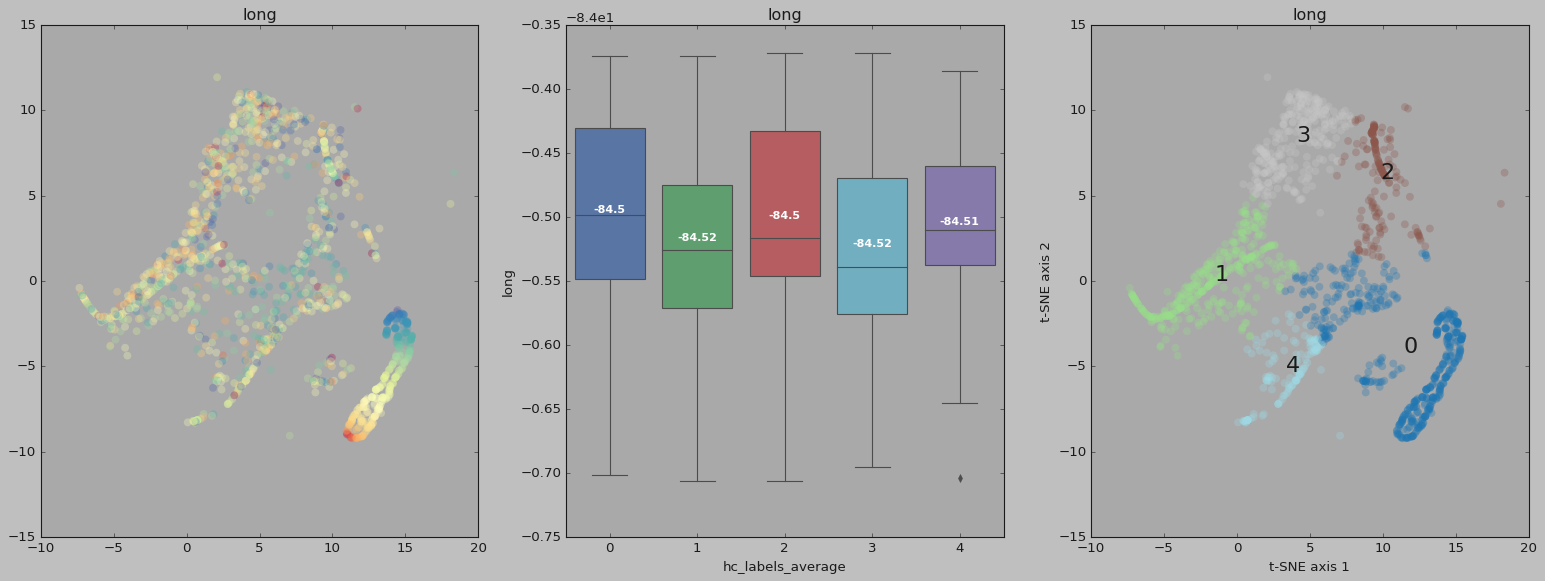

*************************  Name


ValueError: Invalid RGBA argument: 'Mt. Lookout'

In [145]:
# boxplot across clusters for each feature ...
import seaborn as sns
sns.set_palette("husl")
plt.style.use('classic')

col_names = X_all_together.columns.values.tolist()

for col in col_names :
    
    print("************************* ",col)
    _ = plt.figure(figsize=(24, 8));
    
# ... feature distribution color map 

    _ = plt.subplot(131, facecolor = 'darkgrey');
    
    _ = plt.scatter(X_all_together['x-tsne'], X_all_together['y-tsne'],
                 c = X_all_together[col],
                 cmap = plt.cm.Spectral,
                 s = 50,
                 linewidths = 0,
                 alpha = 0.30)
    _ = plt.title(col)
    
# ... feature boxplots

    _ = plt.subplot(132, facecolor = 'darkgrey');
    ax = sns.boxplot(x = "hierarchical", y = col, data = X_all_together);
    #sns.axlabel(xlabel="hc_labels_complete");
    _ = plt.xlabel("hc_labels_average");
    _ = plt.title(col)
    
    average_values = X_all_together.groupby(['hierarchical'])[col].mean().values
    average_labels = [str(np.round(s, 2)) for s in average_values]

    pos = range(len(average_values))
    for tick, label in zip(pos, ax.get_xticklabels()):
        
        _ = ax.text(pos[tick], average_values[tick], average_labels[tick], 
                horizontalalignment = 'center', size = 'small', color = 'w', weight = 'semibold')

# ... cluster color map
    
    _ = plt.subplot(133, facecolor = 'darkgrey');
    
    _ = plt.scatter(X_all_together['x-tsne'], X_all_together['y-tsne'],
                 c = hc_labels_average,
                 cmap = plt.cm.tab20,
                 s = 50,
                 linewidths = 0,
                 alpha = 0.30)
    for ii in range(n_lda) :                                       
           _ = plt.text(hc_average_centers_x[ii], hc_average_centers_y[ii], ii, fontsize = 20)
        
    _ = plt.xlabel('t-SNE axis 1')
    _ = plt.ylabel('t-SNE axis 2')
    _ = plt.title('t-SNE 2-D mapping')
    _ = plt.title(col)
    plt.savefig("C:/Users/Preeti/Github/CapstoneProject/unsupervised/plots/hierarchical/HC_average_%s.png" %col)
    _ = plt.show();